## **Import packages for analysis**

Want to (1) get params at each time, changes from cortisol response (DEX) (2) can meK-Means separate 0 vs 2hr with all counts?

In [1]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/') #OR pip install monod

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, mminference

from monod.analysis import *


In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats
import os

import anndata
import scanpy as sc
import glob

In [4]:
#Packages for Leiden comparison
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import igraph as ig
import leidenalg as la

import itertools

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Read in data and metadata**

Important quotes from the text:

"we assume mRNA half-lives are consistent across different DEX treatment durations. This assumption is further validated by self-consistency check later. "

llustrative of this, the classic markers for GR response, FGD428 and FKBP53
"To jointly make use of the information conveyed by the whole and newly synthesized transcriptomes, we combined their top principal components (PCs) for UMAP analysis"

The 29 TFs with one or more gene links included well-established GR response effectors such as CEBPB41, FOXO142, and JUNB43 (Supplementary Fig. 3cd). This group also included several TFs not previously implicated in GR response, including YOD1 and GTF2IRD1, both of which exhibited greater expression and activity in DEX-treated cells (Supplementary Fig. 3ef). The main TFs driving cell cycle progression were also identified, e.g. E2F1, E2F2, E2F7, BRCA1, MYBL244.

GATA345, mostly expressed in a subset of quiescent cells, as well as TFs involved in oxidative stress response such as NRF146 and NFE2L2 (NRF2)

In [6]:
!wget --content-disposition https://github.com/pachterlab/CGP_2024_2/raw/main/metadata/cao_metadata.tar.gz
!tar -xvf cao_metadata.tar.gz

--2024-07-03 09:11:11--  https://github.com/pachterlab/CGP_2024_2/raw/main/metadata/cao_metadata.tar.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/metadata/cao_metadata.tar.gz [following]
--2024-07-03 09:11:11--  https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/metadata/cao_metadata.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2921211 (2.8M) [application/octet-stream]
Saving to: ‘cao_metadata.tar.gz’

cao_metadata.tar.gz 100%[===================>]   2.79M  --.-KB/s    in 0.03s   

2024-07-03 09:11:11 (111 MB/s) - ‘cao_metadata.tar.gz’ saved [

In [ ]:
#Download gene length references
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/reference/gg_200525_genome_polyA_cum_3

In [ ]:
#Download U and S counts for treated/untreated cells
!wget --content-disposition https://shendure-web.gs.washington.edu/content/members/cao1025/public/sci_fate/sci-A549.loom

In [7]:
#Degradation rates from paper Cao et al. 2020
#Downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3770930


meta_path = "./"
meta = pd.read_csv(meta_path+'cao_GSM3770930_A549_cell_annotate.txt',header=0)
meta['sample'] = ['sci-A549:'+i+'.bam' for i in meta['sample']]
meta.head()

,sample,all_exon,all_intron,all_reads,treatment_time,doublet_score
0,sci-A549:sci-A549-001.ACTCTCTCAA.bam,31785.0,6225.0,41737.0,4h,0.107050
1,sci-A549:sci-A549-001.AAGAAGTTCA.bam,31194.0,2514.0,36264.0,6h,0.036959
2,sci-A549:sci-A549-001.ACGGAGAATA.bam,17207.0,2270.0,21127.0,8h,0.044974
3,sci-A549:sci-A549-001.CGATCCTGGA.bam,14282.0,1932.0,17723.0,4h,0.037975
4,sci-A549:sci-A549-001.ACTGAATTCC.bam,32336.0,8779.0,44778.0,6h,0.077990


In [8]:
#Degradation rates from paper Cao et al. 2020
gammas = pd.read_csv(meta_path+'cao_NIHMS1573440_supp2_deg.csv',header=1)
gammas.head()

,gene_id,gene_type,gene_short_name,half_life_hour
0,ENSG00000228463.4,lincRNA,AP006222.2,0.945733
1,ENSG00000230021.3,lincRNA,RP5-857K21.4,4.351820
2,ENSG00000225972.1,pseudogene,MTND1P23,2.235362
3,ENSG00000225630.1,pseudogene,MTND2P28,1.452221
4,ENSG00000237973.1,pseudogene,hsa-mir-6723,0.871835


In [9]:
#DE genes between 0 and 2hr DEX treatment

des = pd.read_csv(meta_path+'cao_NIHMS1573440_supp2_DE.csv',header=0)
des.head()

,gene_id,gene_short_name,group_with_max_expression,group_with_second_max_expression,max.expr,second.expr,fold.change,pval,qval,RNA_group
0,ENSG00000116285.8,ERRFI1,2h,0h,1486.296241,365.427465,4.067197,0.0,0.0,newly_synthesized_RNA
1,ENSG00000115756.8,HPCAL1,2h,0h,794.897311,224.157008,3.546050,0.0,0.0,newly_synthesized_RNA
2,ENSG00000204634.8,TBC1D8,2h,0h,947.177641,306.551292,3.089717,0.0,0.0,newly_synthesized_RNA
3,ENSG00000181722.11,ZBTB20,2h,0h,3162.362326,1057.057671,2.991646,0.0,0.0,newly_synthesized_RNA
4,ENSG00000124882.3,EREG,0h,2h,717.666770,170.902985,4.199077,0.0,0.0,newly_synthesized_RNA


In [10]:
#DE  Genes for DEX From Reddy et al. 2009, https://genome.cshlp.org/content/19/12/2163.long
reddy = pd.read_csv(meta_path+'reddy_gr_response.csv',header=0)
reddy.head()

,gene,dex.r1,dex.r2,etoh.r1,etoh.r2,Log2 Ratio,# Peaks,Reference,Isoform,RT-QPCR Fold,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,PTGER4,2.3777,2.7362,0.2474,0.2835,3.267912,0,0.0,uc003jlz.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SOCS1,2.4536,2.4708,0.3247,0.1969,3.238932,0,4.0,uc002dar.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TSC22D3,26.6323,27.6177,2.9950,3.3412,3.097933,0,1.0,uc004eng.1,2.966667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SPRY1,1.0414,1.1470,0.1336,0.1496,2.949983,0,1.0,uc003ifb.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RASD1,2.1441,1.9957,0.4086,0.1418,2.911009,1,5.0,uc002gri.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Downloaded from https://shendure-web.gs.washington.edu/content/members/cao1025/public/sci_fate/sci-A549.loom
ds = lp.connect('./sci-A549.loom')

In [14]:
ds.ra.keys()

['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']

In [15]:
ds.ca.keys()

['CellID']

In [16]:
cellids = ds.ca['CellID']

In [17]:
ds.close()

In [16]:
#Named markers in study

markers = ['BBC3','FGD4','FKBP4','FKBP5','CEBPB','JUNB','YOD1',
          'E2F1','E2F2','E2F7','BRCA1','SRSF3']

Set up files/output files for *Monod* runs

In [17]:
dataset_meta = ['sci-A549']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [['0h'],['2h'],['0h','2h']] #Cells from treatment times to fit on

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['cao_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = './gg_200525_genome_polyA_cum_3' 

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'Gene'
cell_attr = 'CellID'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['./'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['sci-A549']

dataset_names:  ['cao_sci-A549_0h', 'cao_sci-A549_2h', 'cao_sci-A549_0h_2h']
len(dataset_names):  3

loom_filepaths:  ['/home/tchari/counts/cao_scifate/loom/sci-A549.loom', '/home/tchari/counts/cao_scifate/loom/sci-A549.loom', '/home/tchari/counts/cao_scifate/loom/sci-A549.loom']


**Get boolean filter cell barcodes in loom for each timepoint**

In [18]:
cf = []
cellids = pd.Categorical(cellids)
for s in subcluster_names:
    cf.append(cellids.isin(list(meta['sample'][meta['treatment_time'].isin(s)])))

In [19]:
len(cf)

3

# *Monod* Technical Parameter Grid Search

## **Gene Filtering**

Filter for moderately expressed genes across cells

In [20]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [22]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


Initially fit Monod on the timepoints to see which technical sampling parameters best fit (data was sequenced together).

Select high expression genes that are not very variable across samples for this fitting.

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_240405_029_tech_1 created.
INFO:root:Dataset: cao_sci-A549_0h
INFO:root:1151 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4048 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h created.
INFO:root:Dataset: cao_sci-A549_2h
INFO:root:1189 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4066 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_2h created.
INFO:root:Dataset: cao_sci-A549_0h_2h
INFO:root:2340 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4756 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h created.
INFO:root:Total of 500 genes selected.
INFO

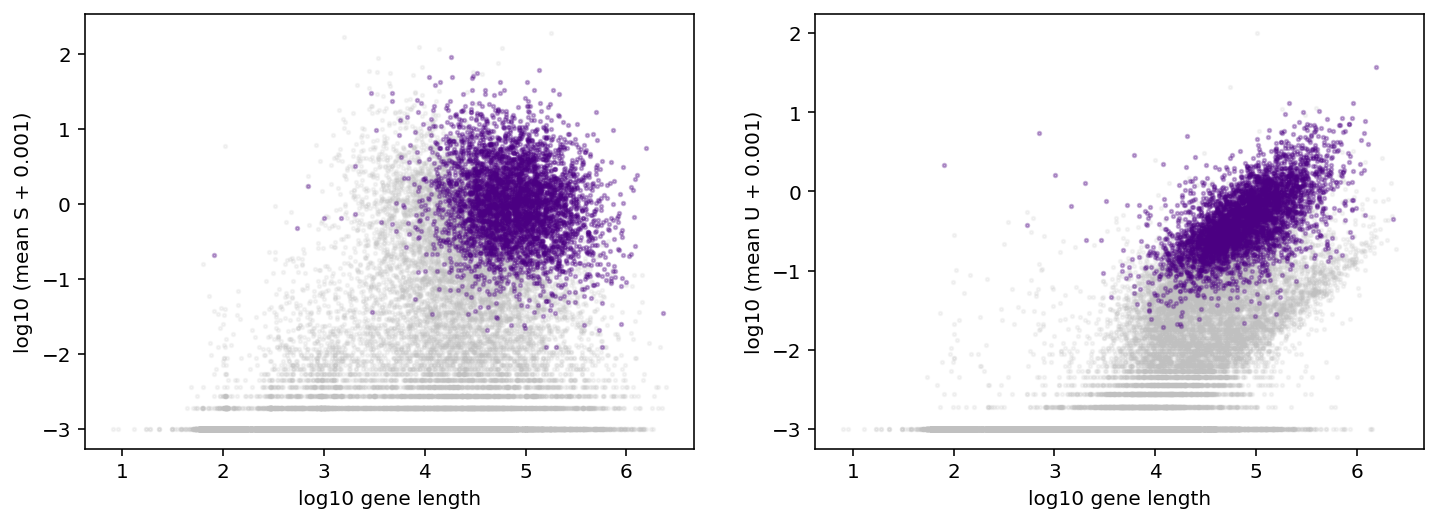

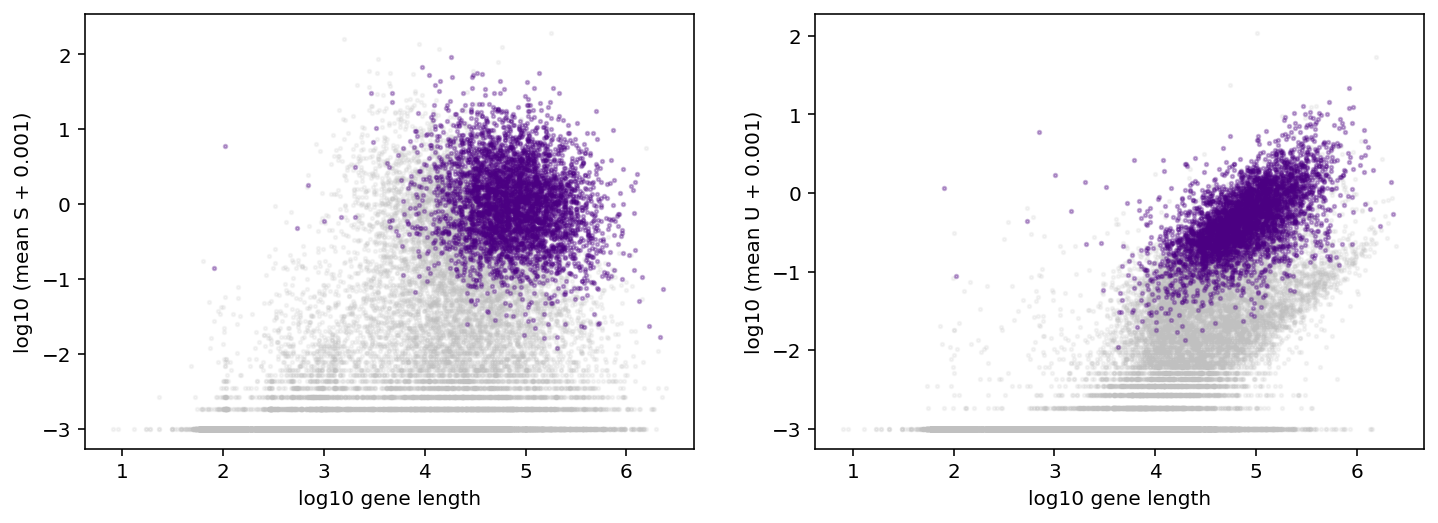

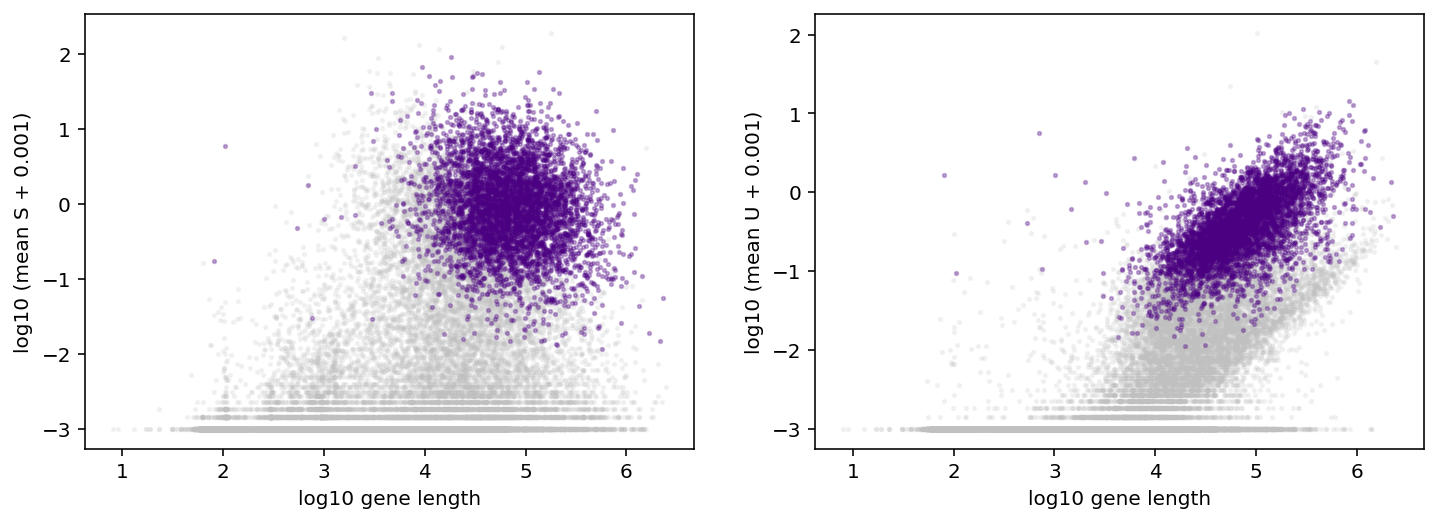

In [23]:
#Set the marker genes to be fit if possible
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='tech',batch_id=1,\
                                             n_genes=500,exp_filter_threshold=None,cf=cf) #ONLY USE 500 GENES

In [24]:
dir_string = './fits/gg_240405_029_tech_1' #Set to current dir_string if new run
dataset_strings = [dir_string+'/'+i for i in dataset_names]


In [25]:
print(dataset_strings)
print(len(dataset_strings))

['./fits/gg_240405_029_tech_1/cao_sci-A549_0h', './fits/gg_240405_029_tech_1/cao_sci-A549_2h', './fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h']
3


## **Run *Monod* Parameter Inference**
Running inference to fit technical sampling parameters. Should be similar since sequenced together.

In [26]:
#Define bounds
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11] #20,21 #run across grid of technical/sampling parameters

In [27]:
print(len(dataset_strings))

3


INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_sci-A549_0h
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/gg_240405_029_tech_1/genes.csv.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:13<00:00,  1.21s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 135.1 seconds.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_sci-A549_2h
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/gg_240405_029_tech_1/genes.csv.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:18<00:00,  1.26s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 140.4 seconds.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_sci-A549_0h_2h
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/gg_240405_029_tech_1/genes.csv.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:34<00:00,  1.40s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 155.8 seconds.


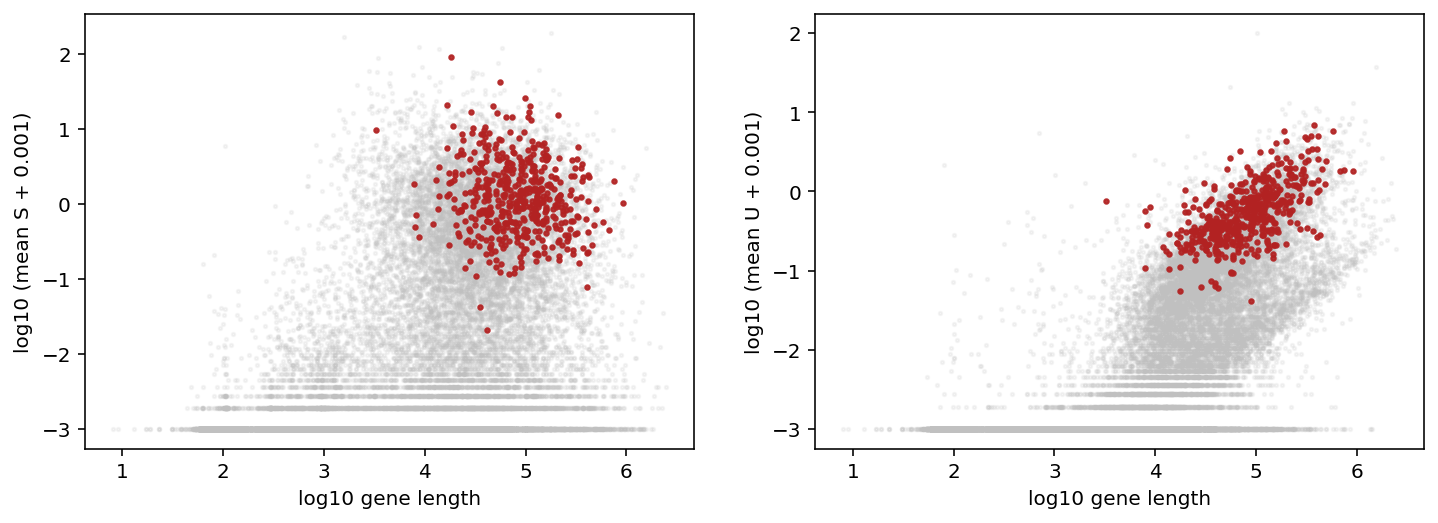

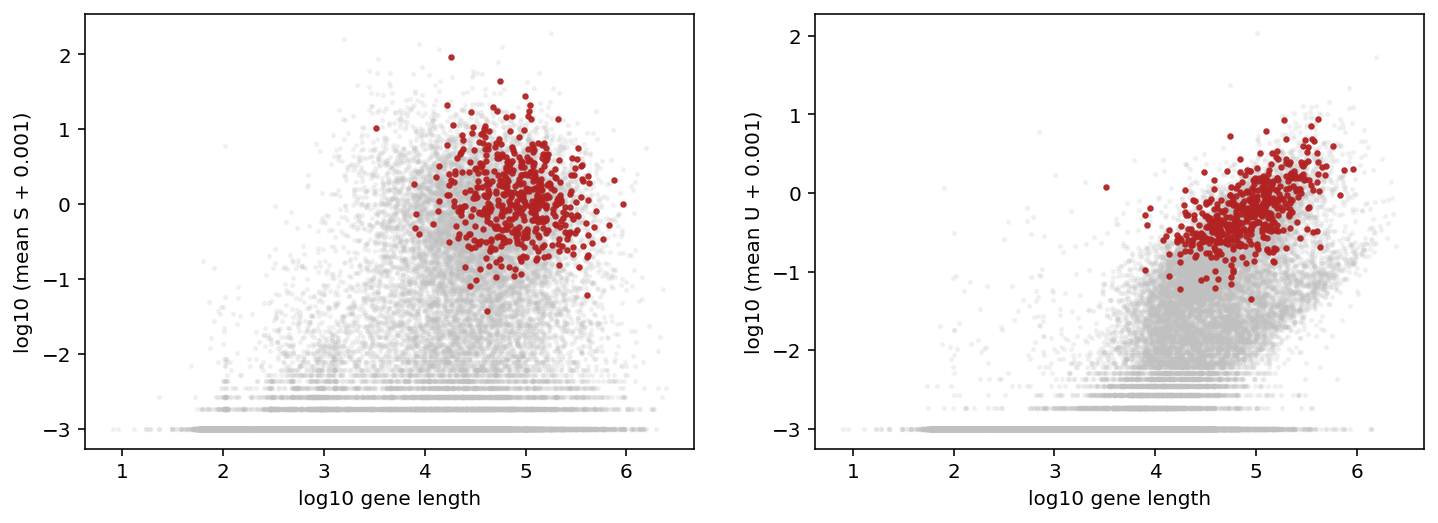

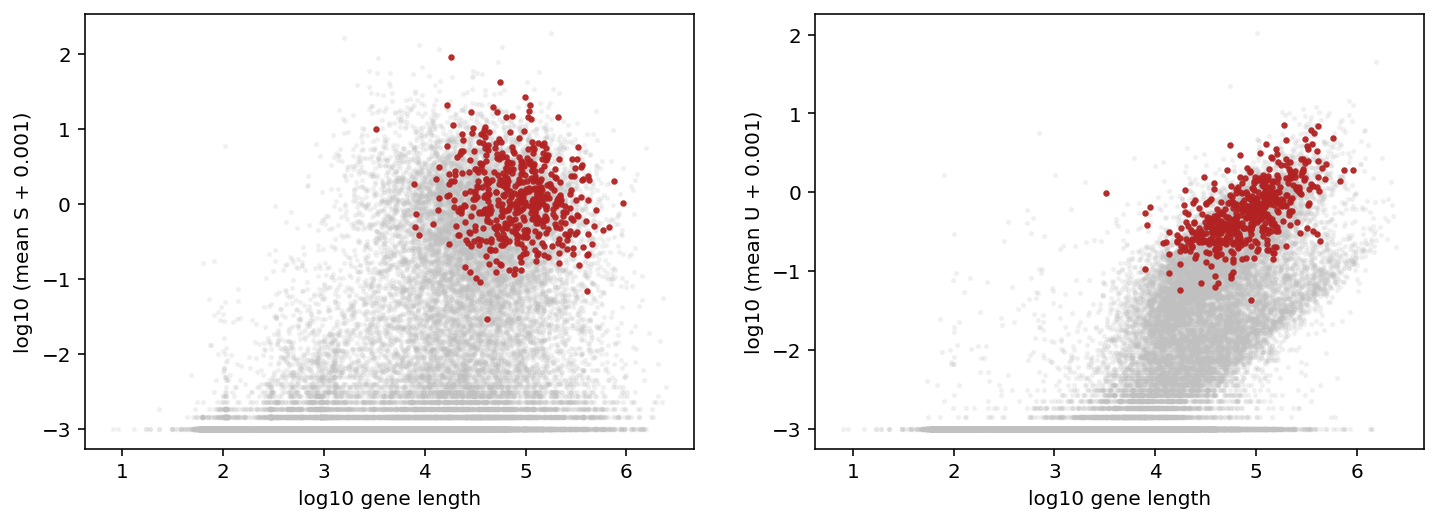

In [28]:
result_strings = []
for i in range(n_datasets): #Re-run datasets that were never fit, [7:]
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [29]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings] #20x21
print(result_strings[0])

./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/grid_scan_results.res


## **QC and Analysis of Results of  Tech Param Fits**

In [28]:
n_datasets

3

INFO:root:Grid scan results loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/analysis_figures/kldiv.png.
INFO:root:Chi-square computation complete. Rejected 35 genes out of 500. Runtime: 1.4 seconds.
INFO:root:Original optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 35 genes out of 500. Runtime: 1.3 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 35 genes out of 500. Runtime: 1.3 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 35 genes out of 500. Runtime: 1.3 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 35 genes out of 500. Runtim

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/Bursty_Poisson_10x11/analysis_figures/length_dependence.png.
INFO:root:Directory ./fits/gg_240405_029_tech_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11/analysis_figures/kldiv.png.
INFO:root:Chi-square computation complete. Rejected 21 genes out of 500. Runtime: 1.8 seconds.
INFO:root:Original optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 21 genes out of 500. Runtime: 1.8 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 21 genes out of 500. Runtime: 1.8 seconds.
INFO:root:New optimum: -6.

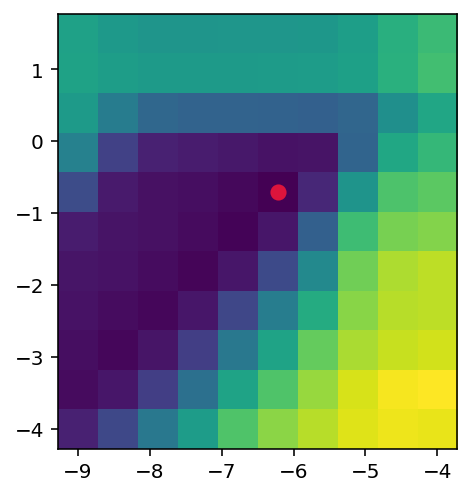

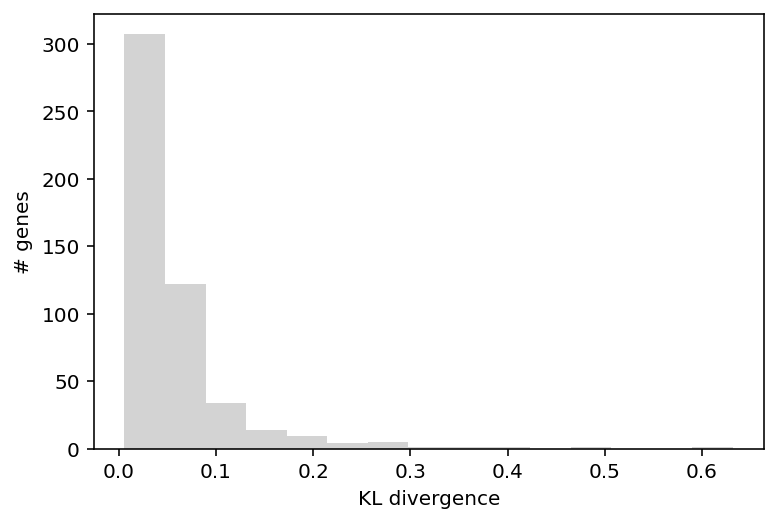

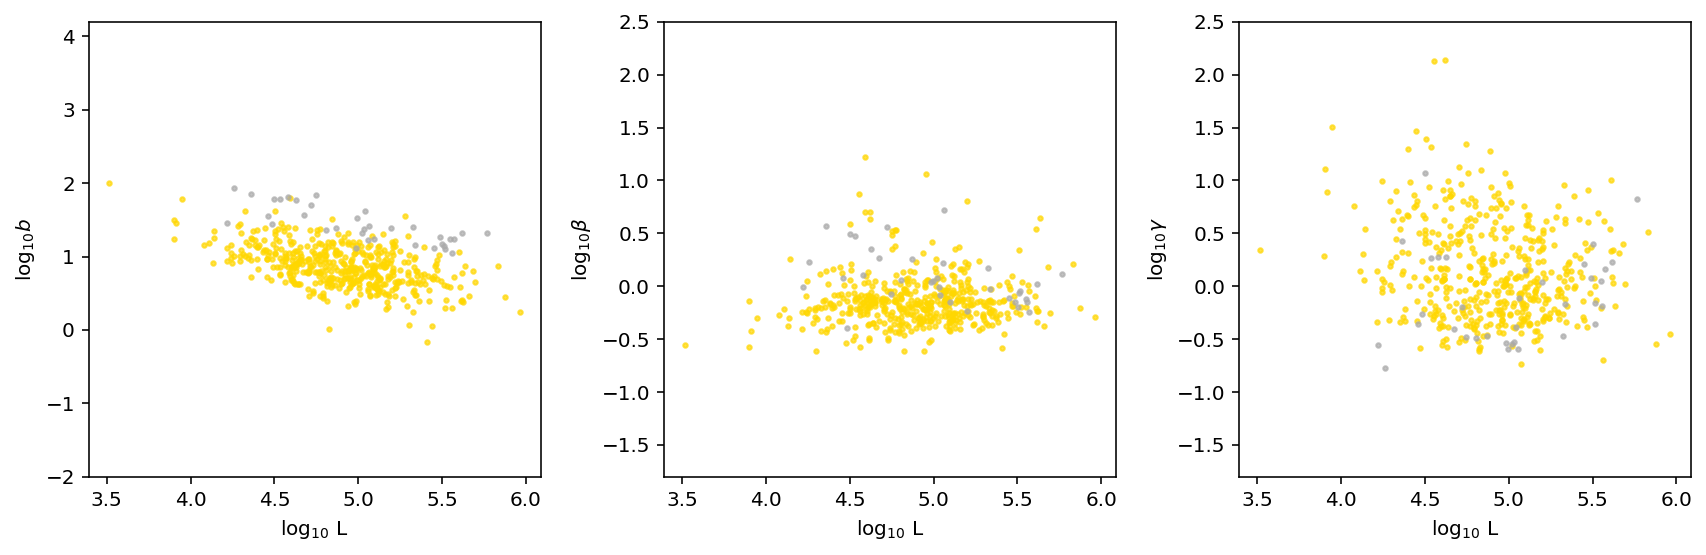

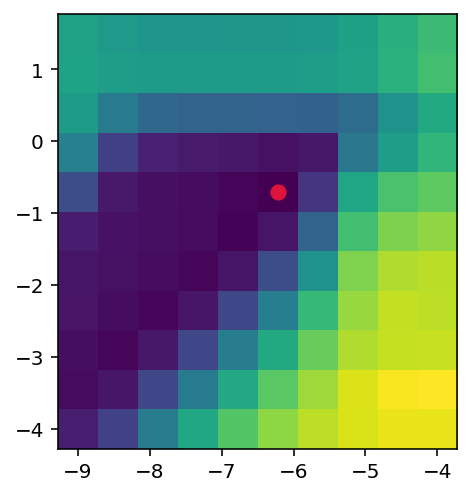

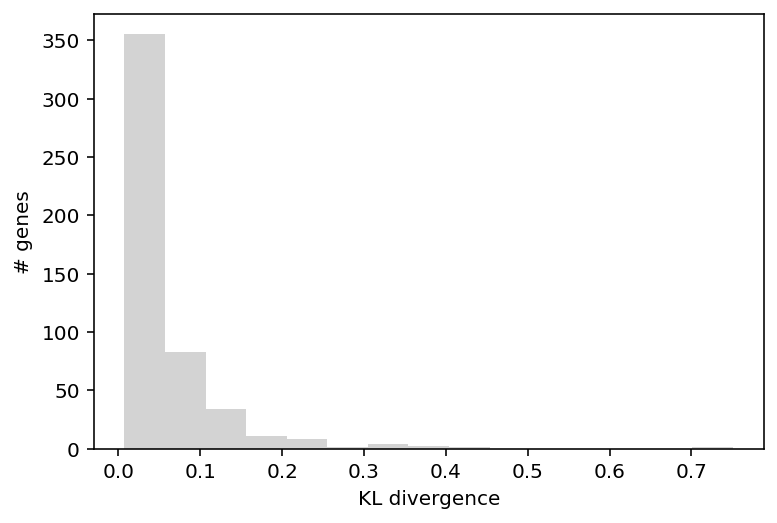

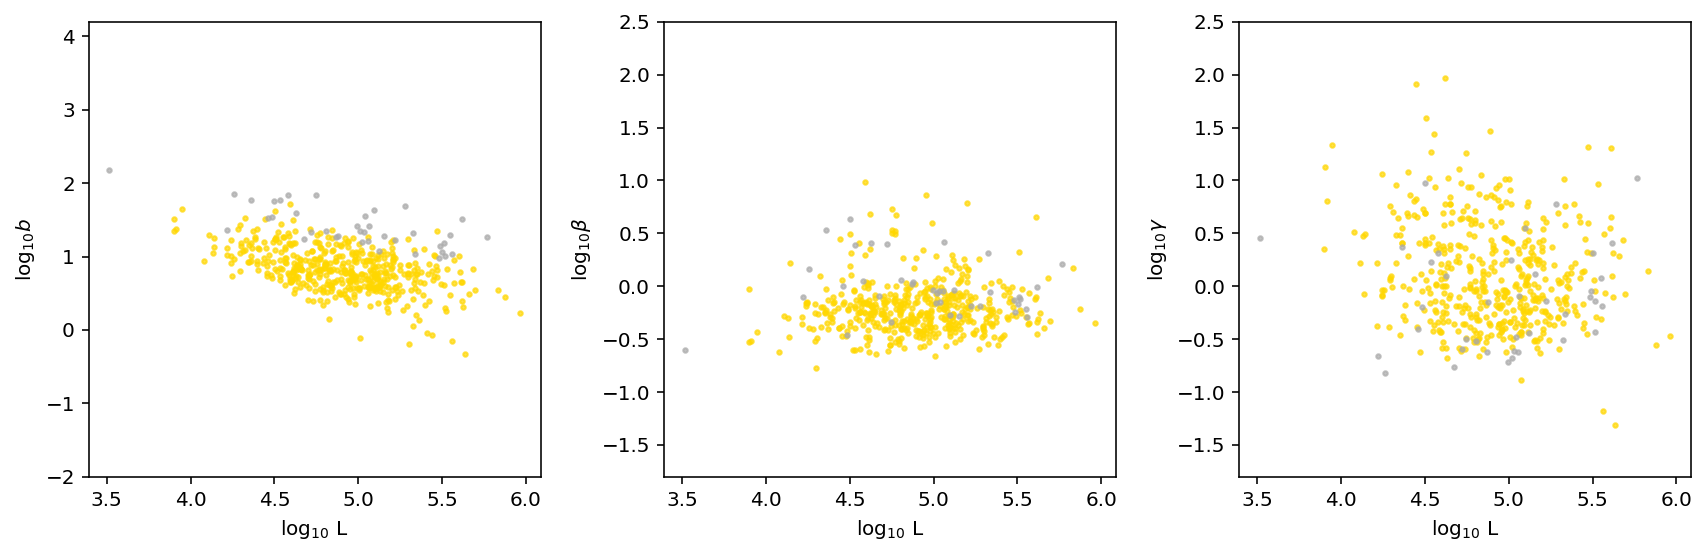

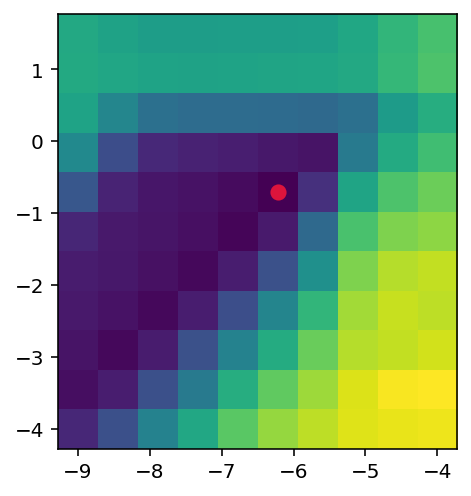

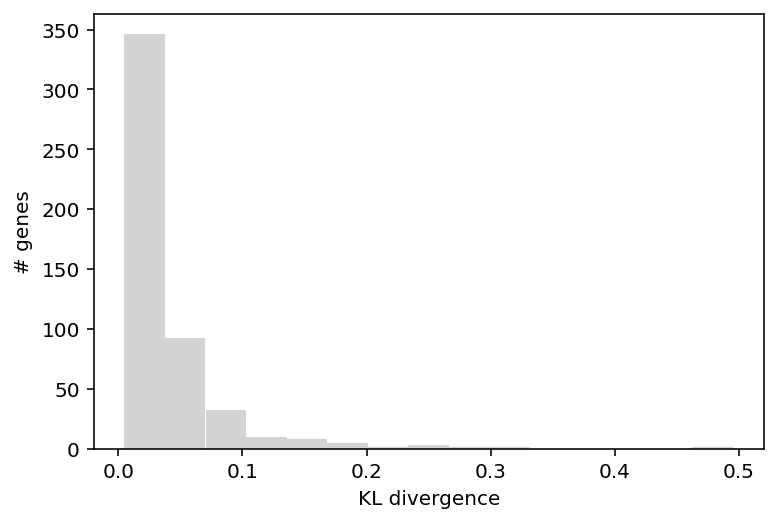

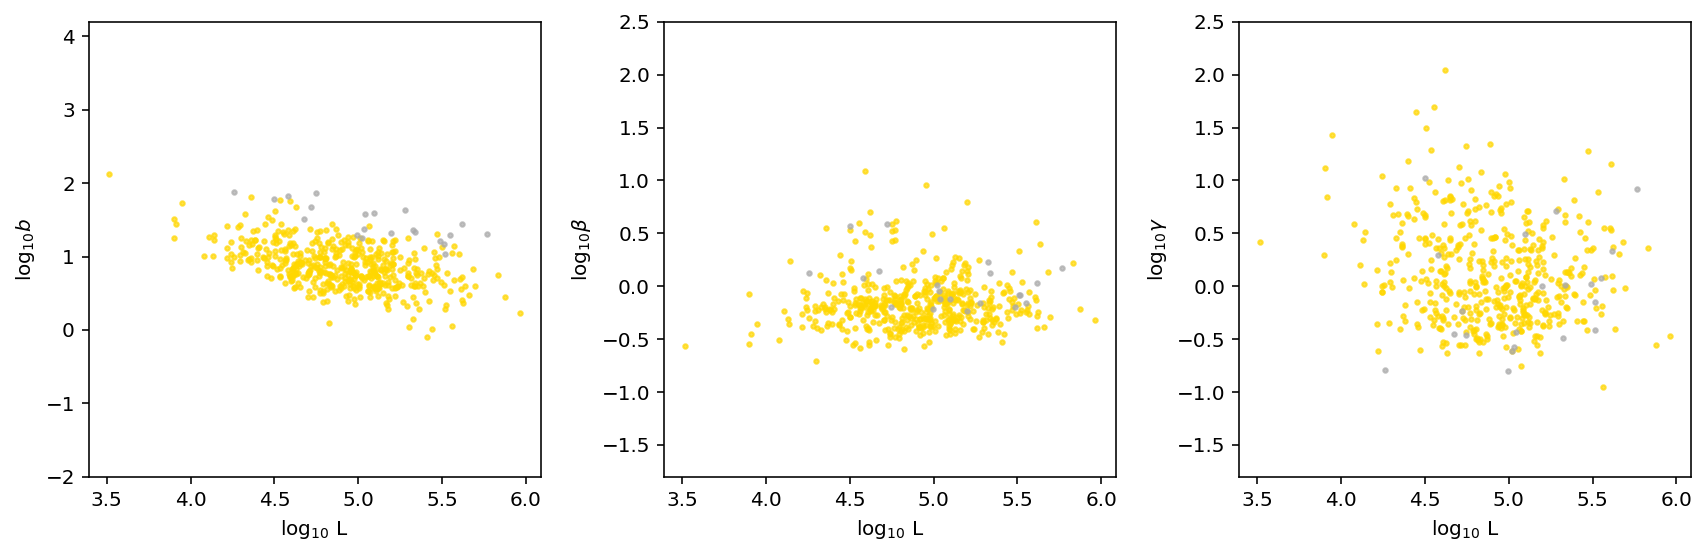

In [31]:
#Run tests for gene rejection and uncertainty calcs (std error of params)
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    #Chi sq rejection
    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

    sr.compute_sigma(sd,num_cores=30) #Compute std error for parameters
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [32]:
#Read back in results
sr_arr = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

INFO:root:Grid scan results loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h/Bursty_Poisson_10x11/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_2h/Bursty_Poisson_10x11/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_240405_029_tech_1/cao_sci-A549_0h_2h/Bursty_Poisson_10x11/grid_scan_results_upd.res.


In [33]:
for i in range(len(sr_arr)):
    sr = sr_arr[i]
    print(str(i)+': '+dataset_names[i])
    print(str(i)+': '+str(sr.samp_optimum))
    print()

0: cao_sci-A549_0h
0: (-6.222222222222222, -0.6999999999999997)

1: cao_sci-A549_2h
1: (-6.222222222222222, -0.6999999999999997)

2: cao_sci-A549_0h_2h
2: (-6.222222222222222, -0.6999999999999997)



# *Monod* and meK-Means Fits on Genes of Interest

In [84]:
!mkdir /home/tchari/perturbCME/notebooks/fits/explorCao_0405

***Monod* Fit on 0h and 2h cells**


In [85]:
result_strings = []


#for loom,transc,data_name,g_lit,tech_tup,f in zip(loom_filepaths,transcrips,dataset_names,all_markers,tech_params,cf):

#Define bounds for params
phys_lb = [-3.0, -3, -3 ] 
phys_ub = [4.2, 2.5, 2.5]  
samp_lb = [-6.222222222222222, -0.6999999999999997] 
samp_ub = [-6.222222222222222, -0.6999999999999997]
gridsize = [1,1] #Already have tech params



#Set up files for Monod, FIT ALL DATASETS ON SAME 3K GENES
dir_string,dataset_string = monod.preprocess.construct_batch(loom_filepaths, \
                                         transcriptome_filepath, \
                                         dataset_names, \
                                         attribute_names=attribute_names,\
                                         batch_location='./fits/explorCao_0405',\
                                         meta='monod',batch_id=1,\
                                         n_genes=3000,exp_filter_threshold=None,
                                         viz=False,genes_to_fit=markers,cf=cf) #explorData_0313
# dir_strings += [dir_string]
# data_strings += [dataset_string]

# ---------------- meK-Means Inference ---------------- 
for x in range(len(dataset_string)):
    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_string[x],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[x],transcriptome_filepath, dataset_names[x],
                dataset_string[x], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[x])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

    result_strings.append(full_result_string)
    print('Result: ',full_result_string)


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1 created.
INFO:root:Dataset: cao_sci-A549_0h
INFO:root:1151 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4048 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h created.
INFO:root:Dataset: cao_sci-A549_2h
INFO:root:1189 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4066 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h created.
INFO:root:Dataset: cao_sci-A549_0h_2h
INFO:root:2340 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4756 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:19<00:00, 79.95s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 86.5 seconds.
Result:  ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/grid_scan_results.res
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_sci-A549_2h
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/explorCao_0405/gg_240405_029_monod_1/genes.csv.
INFO:root:Search data stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/raw.sd.
INFO:root:Starting parallelized grid scan.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:21<00:00, 81.31s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 88.0 seconds.
Result:  ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/grid_scan_results.res
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_sci-A549_0h_2h
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/explorCao_0405/gg_240405_029_monod_1/genes.csv.
INFO:root:Search data stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/raw.sd.
INFO:root:Starting parallelize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:15<00:00, 75.98s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 82.6 seconds.
Result:  ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/grid_scan_results.res


In [39]:
dir_string = './fits/explorCao_0405/gg_240405_029_monod_1' #
dataset_strings = [dir_string+'/'+i for i in dataset_names]
dataset_strings

['./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h',
 './fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h',
 './fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h']

In [40]:
#Read back in results
result_strings = [d+'/Bursty_Poisson_1x1/grid_scan_results.res' for d in dataset_strings]
result_strings

['./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/analysis_figures/kldiv.png.
INFO:root:Chi-square computation complete. Rejected 229 genes out of 3000. Runtime: 8.5 seconds.
INFO:root:Original optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 229 genes out of 3000. Runtime: 8.2 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 229 genes out of 3000. Runtime: 8.3 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 229 genes out of 3000. Runtime: 8.3 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square comput

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/analysis_figures/length_dependence.png.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/analysis_figures/kldiv.png.
INFO:root:Chi-square computation complete. Rejected 227 genes out of 3000. Runtime: 8.6 seconds.
INFO:root:Original optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 227 genes out of 3000. Runtime: 8.4 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 227 gen

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/analysis_figures/length_dependence.png.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/analysis_figures/kldiv.png.
INFO:root:Chi-square computation complete. Rejected 148 genes out of 3000. Runtime: 10.2 seconds.
INFO:root:Original optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete. Rejected 148 genes out of 3000. Runtime: 10.0 seconds.
INFO:root:New optimum: -6.22, -0.70.
INFO:root:Chi-square computation complete

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/analysis_figures/length_dependence.png.
INFO:root:Directory ./fits/explorCao_0405/gg_240405_029_monod_1/analysis_figures already exists.


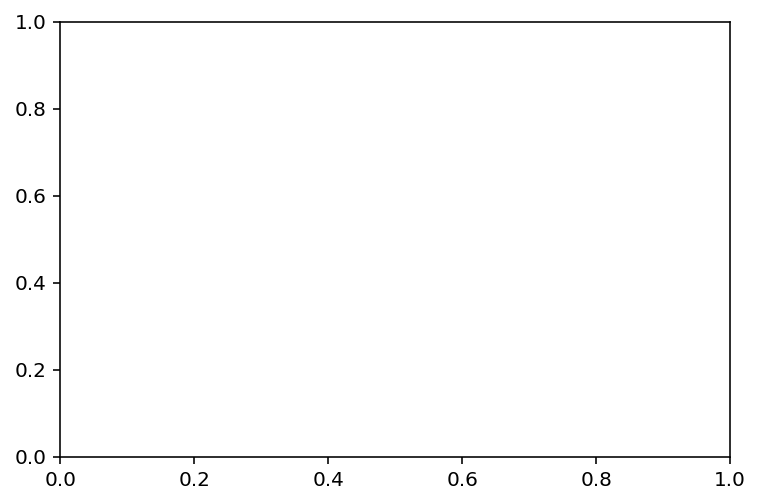

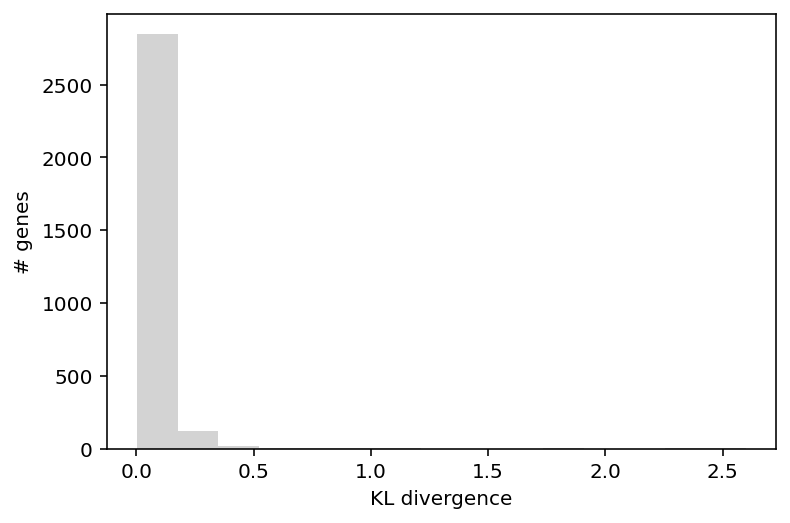

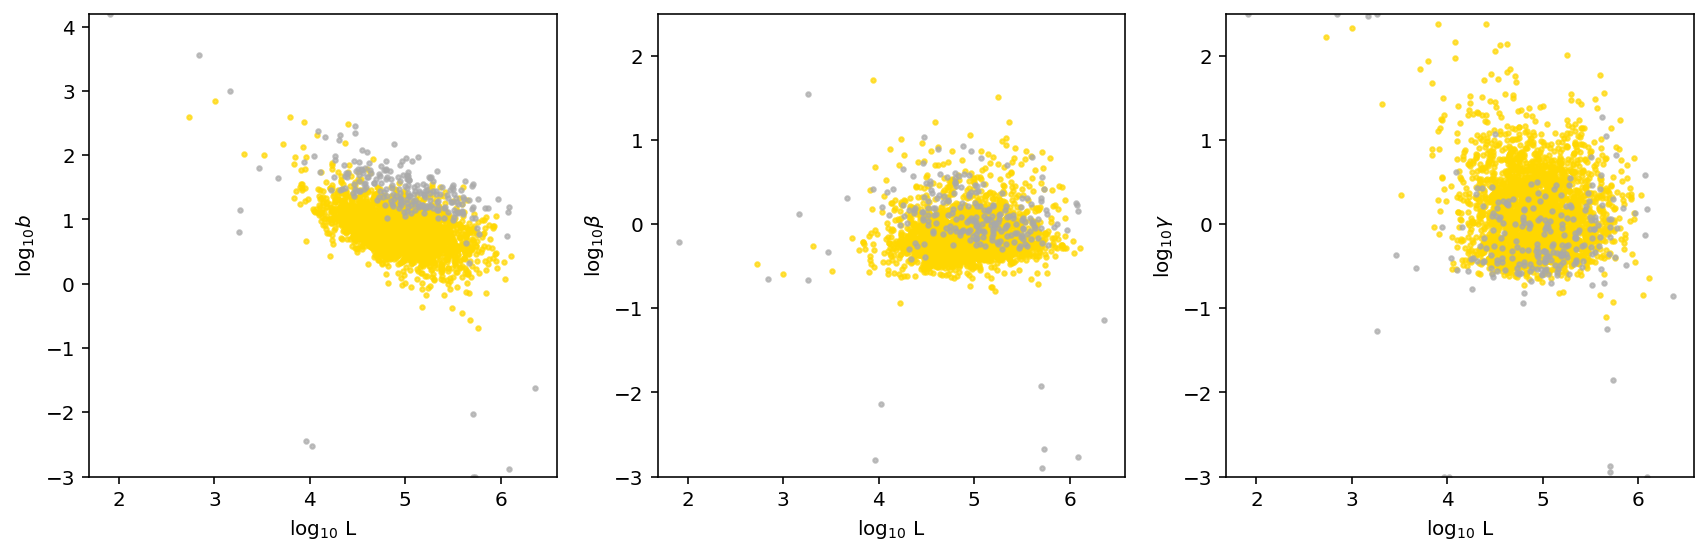

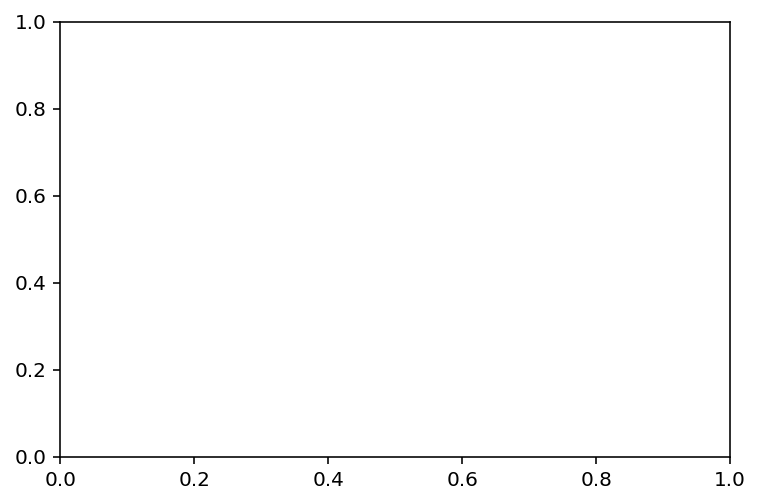

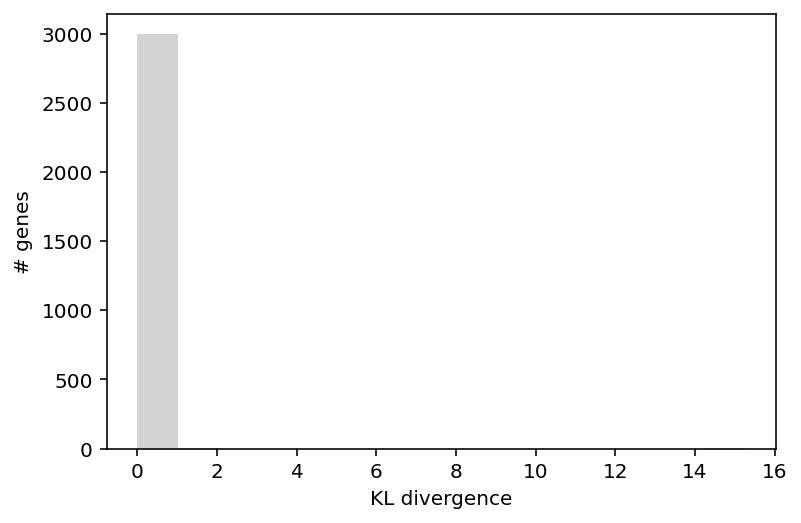

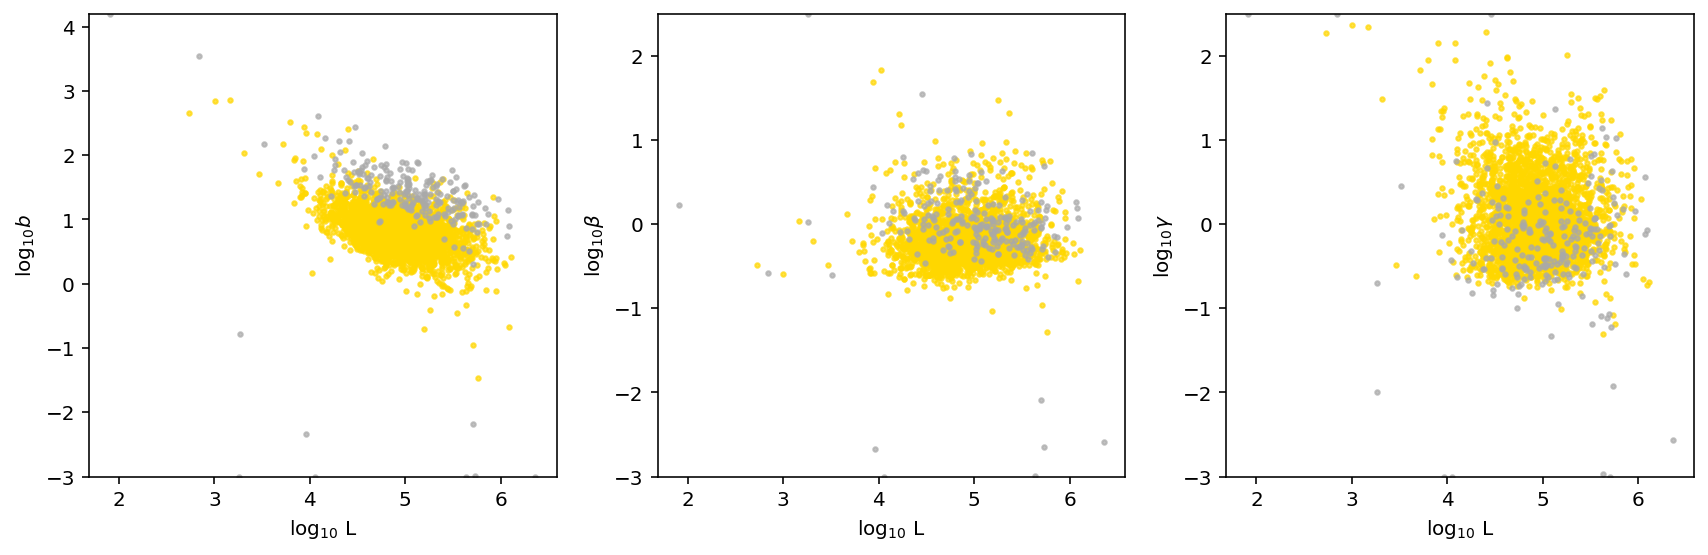

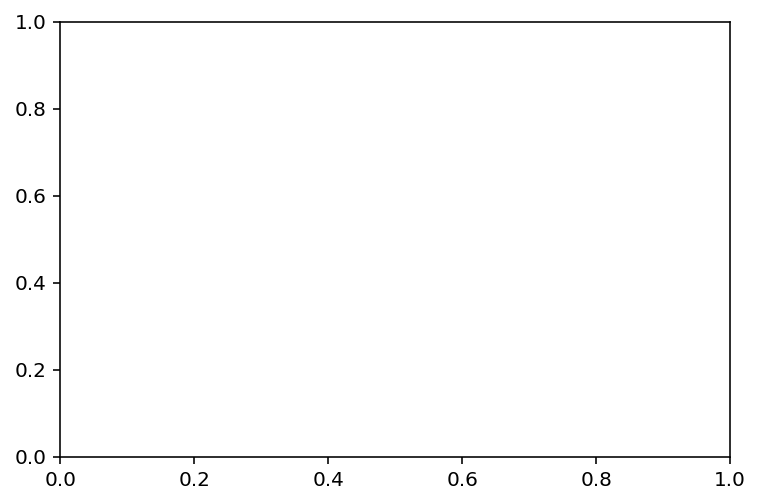

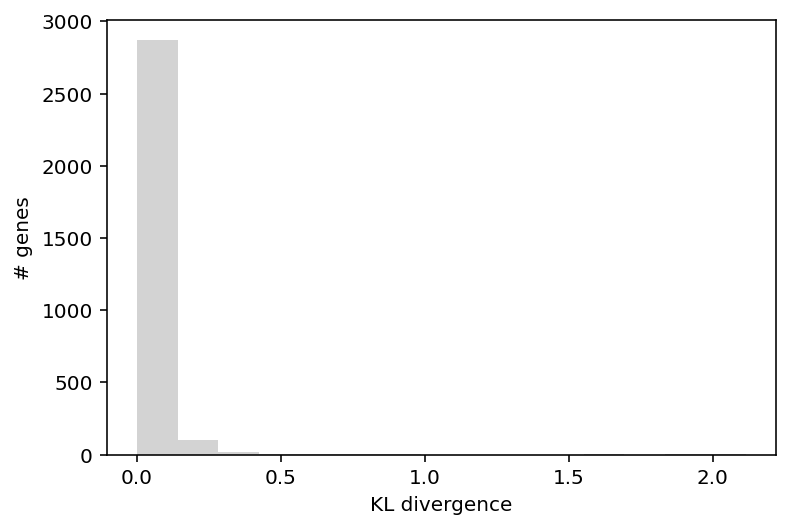

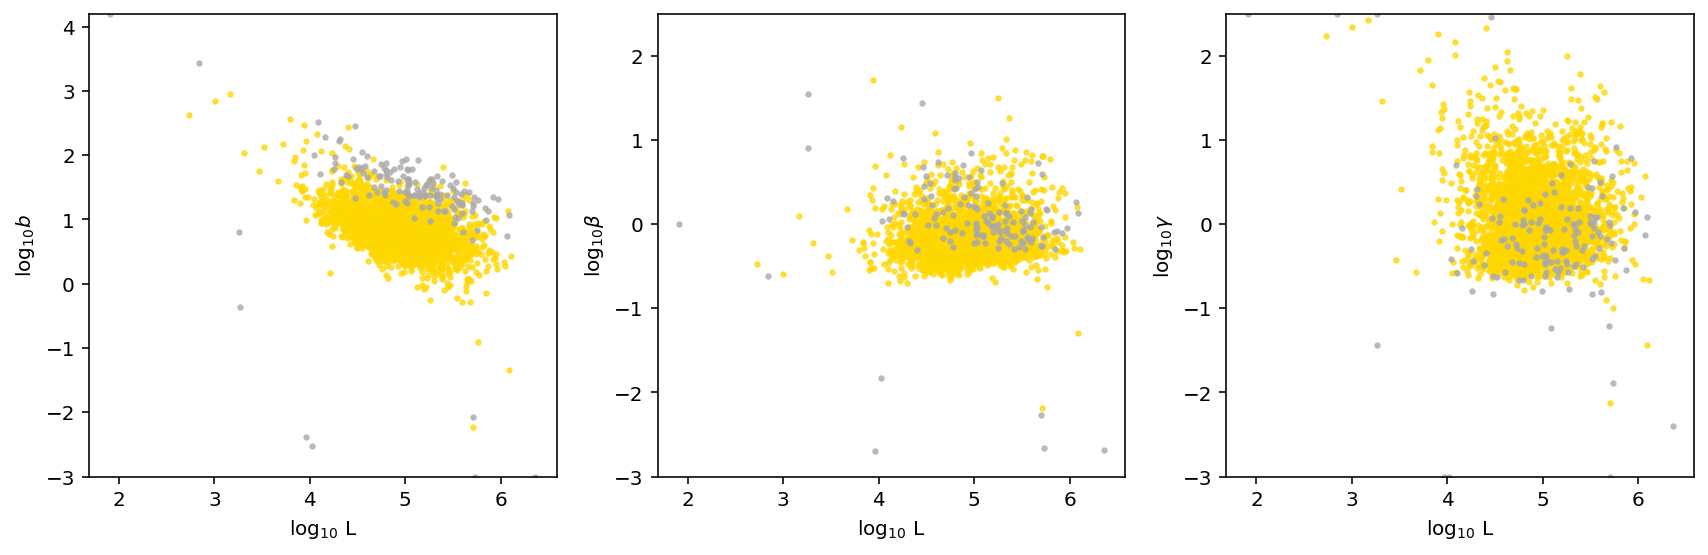

In [91]:
#Run tests for gene rejection and uncertainty calcs (std error of params)
for i in range(len(result_strings)):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    #Chi sq rejection
    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

    sr.compute_sigma(sd,num_cores=30) #Compute std error for parameters
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [41]:
#Read back in results
sr_arr_monod = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/Bursty_Poisson_1x1/grid_scan_results_upd.res.


In [42]:
sd_arr_monod = [monod.analysis.load_search_data(dir_string+'/'+dataset_names[x]+'/raw.sd') for x in range(len(dataset_names))]


INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_2h/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240405_029_monod_1/cao_sci-A549_0h_2h/raw.sd.


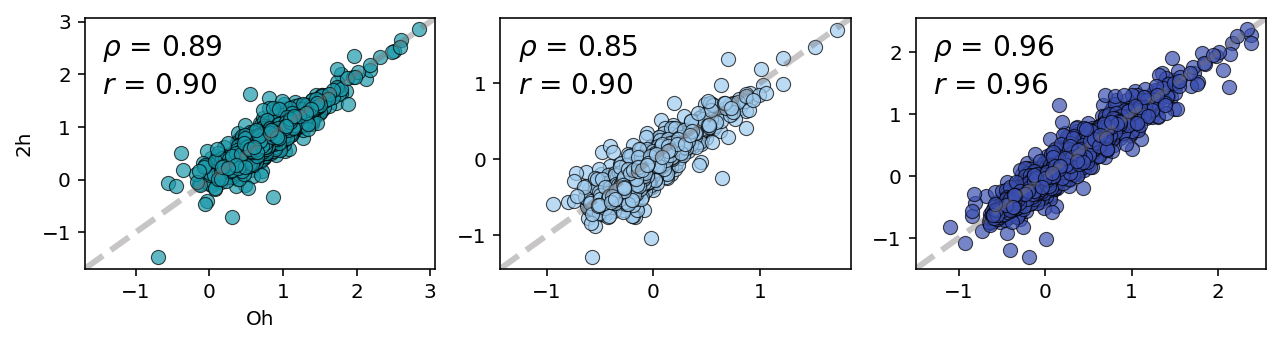

In [518]:
#Check params in 0h vs 2h
gf_rej = ~(sr_arr_monod[0].rejected_genes | sr_arr_monod[1].rejected_genes)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5))
rho =[]
p = [] 

#Colors
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'

#b vs b
g=sns.scatterplot(x=sr_arr_monod[0].param_estimates[0,gf_rej,0],
                  y=sr_arr_monod[1].param_estimates[0,gf_rej,0],
                    s=50,edgecolor='black',color=col_b, alpha=0.7,ax=ax[0],legend=False)

rho += [np.corrcoef(sr_arr_monod[0].param_estimates[0,gf_rej,0],
                    sr_arr_monod[1].param_estimates[0,gf_rej,0])[0,1]]
p += [scipy.stats.spearmanr(sr_arr_monod[0].param_estimates[0,gf_rej,0],
                    sr_arr_monod[1].param_estimates[0,gf_rej,0])[0]]


#beta vs beta
g1=sns.scatterplot(x=sr_arr_monod[0].param_estimates[0,gf_rej,1],
                  y=sr_arr_monod[1].param_estimates[0,gf_rej,1],
                    s=50,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1],legend=False)

rho += [np.corrcoef(sr_arr_monod[0].param_estimates[0,gf_rej,1],
                    sr_arr_monod[1].param_estimates[0,gf_rej,1])[0,1]]
p += [scipy.stats.spearmanr(sr_arr_monod[0].param_estimates[0,gf_rej,1],
                    sr_arr_monod[1].param_estimates[0,gf_rej,1])[0]]

#gammas
g2=sns.scatterplot(x=sr_arr_monod[0].param_estimates[0,gf_rej,2],
                  y=sr_arr_monod[1].param_estimates[0,gf_rej,2],
                    s=50,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2],legend=False)

rho += [np.corrcoef(sr_arr_monod[0].param_estimates[0,gf_rej,2],
                    sr_arr_monod[1].param_estimates[0,gf_rej,2])[0,1]]
p += [scipy.stats.spearmanr(sr_arr_monod[0].param_estimates[0,gf_rej,2],
                    sr_arr_monod[1].param_estimates[0,gf_rej,2])[0]]

ax[0].set_xlabel('Oh')
ax[0].set_ylabel('2h')

for i, a in enumerate(ax.flat):


        bot,top = a.get_ylim()
        left,right = a.get_xlim()

        newl = np.min([bot,left])
        newr = np.max([top,right])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
        a.text(.05,.85,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)


plt.tight_layout()
plt.savefig('cao_Monod_param_corrs.pdf')


Compare gammas from Monod to half-lives (?) from paper

In [130]:
gene_names =  sd_arr_monod[0].gene_names
ind = gene_names =='YOD1'
sr_arr_monod[0].param_estimates[0,ind,:]

array([[-2.44728946, -2.80429542, -3.        ]])

In [131]:
sr_arr_monod[1].param_estimates[0,ind,:]

array([[-2.33200147, -2.66932392, -3.        ]])

In [141]:
g_shorts = list(gammas.gene_short_name)

In [163]:
kept_genes = gene_names[gf_rej]

In [164]:
g_inds = [list(gene_names).index(g) for g in g_shorts if (g in gene_names)&(g in kept_genes)]
g_name= gene_names[g_inds]
g_gammas = [list(gammas.half_life_hour[gammas.gene_short_name.isin([g])])[0] for g in g_name]

In [165]:
g_gammas = np.array(g_gammas)
#g_gammas = 2*np.log(0.5)/np.log(1-g_gammas)

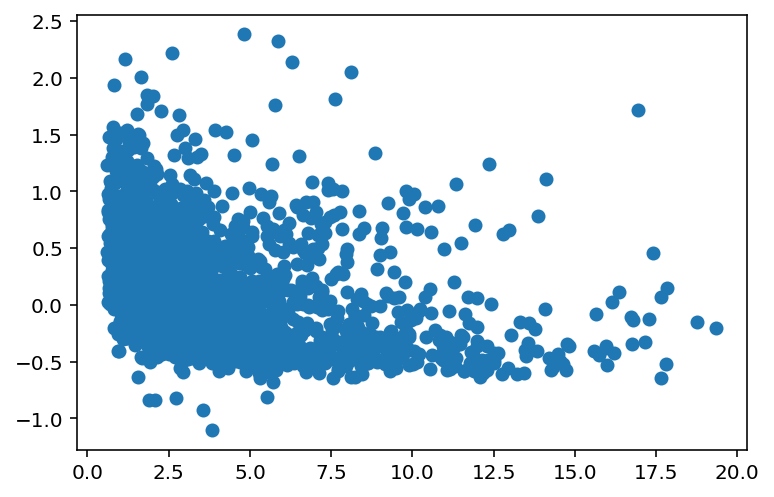

In [185]:
plt.scatter(g_gammas[g_gammas<20],sr_arr_monod[0].param_estimates[0,g_inds,2][g_gammas<20])

In [186]:
np.corrcoef(g_gammas[g_gammas<20],sr_arr_monod[0].param_estimates[0,g_inds,2][g_gammas<20])
            

array([[ 1.        , -0.33648698],
       [-0.33648698,  1.        ]])

### **DE-$\theta$ Analysis**

DE analysis between the 0h and 2h cells

In [21]:
def make_fcs_srs(sr1,sr2,sd1,sd2,gene_names,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False,correct_off=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between clusters in different SRs

    sr1: SearchResults object 1 (single object)
    sr2: SearchResults object 2
    sd1: SearchData object for sr1
    sd2: SearchData object for sr2
    gene_names: list of gene names to compare between SRs
    gf_rej: whether to use boolean list of rejected genes from both SRs
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    correct_off: boolean to correct parameter offset with ODR
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))

    sr1 = sr1
    sr2 = sr2
    
    gfilt1 = [list(sr1.gene_names).index(i) for i in gene_names]
    gfilt2 = [list(sr2.gene_names).index(i) for i in gene_names]
    
    par_vals1 = np.copy(sr1.param_estimates[:,gfilt1,:])
    par_vals2 = np.copy(sr2.param_estimates[:,gfilt2,:])
        
    parnames = ('b','beta','gamma')
    
    if correct_off:
        param_names = sr1.model.get_log_name_str()
        offsets = []
        for k in range(len(param_names)):
            m1 = par_vals1[0,:,k]
            m2 = par_vals2[0,:,k]
            offset = diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
            par_vals2[0,:,k] -= offset

        fc_par = (par_vals1-par_vals2)/np.log10(2)
    else:
        fc_par = (par_vals1-par_vals2)/np.log10(2)  #Get FCs between cluster params
        
    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd1.layers[0][gfilt1,:].mean(1)/sd2.layers[0][gfilt2,:].mean(1)) #Get unspliced FCs
    else:
        fc_s_par = np.log2(sd1.layers[1][gfilt1,:].mean(1)/sd2.layers[1][gfilt2,:].mean(1)) #Get spliced FCs
        
    print('fc_s_par.shape: ',fc_s_par.shape)

    #Use outlier calling method to find DE genes
    if outlier_de:
        if len(sr1.gene_names) != len(sr2.gene_names):
            print('Not running outlier DE. SRs need to have the same gene dimensions.')
            par_bool_de = np.zeros((len(gene_names),len(parnames)))
        else:
            dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
            par_bool_de = dr_analysis[1].T



  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*(len(gfilt1))
    else:
        gf_rej = ~(sr1.rejected_genes[gfilt1]) & ~(sr2.rejected_genes[gfilt2])
        
    
    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd1.layers[0][gfilt1,:].mean(1)>thrmean) | (sd2.layers[0][gfilt2,:].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd1.layers[1][gfilt1,:].mean(1)>thrmean) | (sd2.layers[1][gfilt2,:].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(gene_names[gf_rej])
        which_pair += [[1,2]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


In [22]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]            
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']       
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [23]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]
        
        if if_x:
            shape = 'X'
        else:
            shape = 'o'
            
        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
    
    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

                
            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
        

    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



fc_par.shape:  (1, 3000, 3)
fc_s_par.shape:  (3000,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


INFO:root:Figure stored to ./fits/explorCao_0405/gg_240405_029_monod_1/analysis_figures/parameter_residuals_12.png.


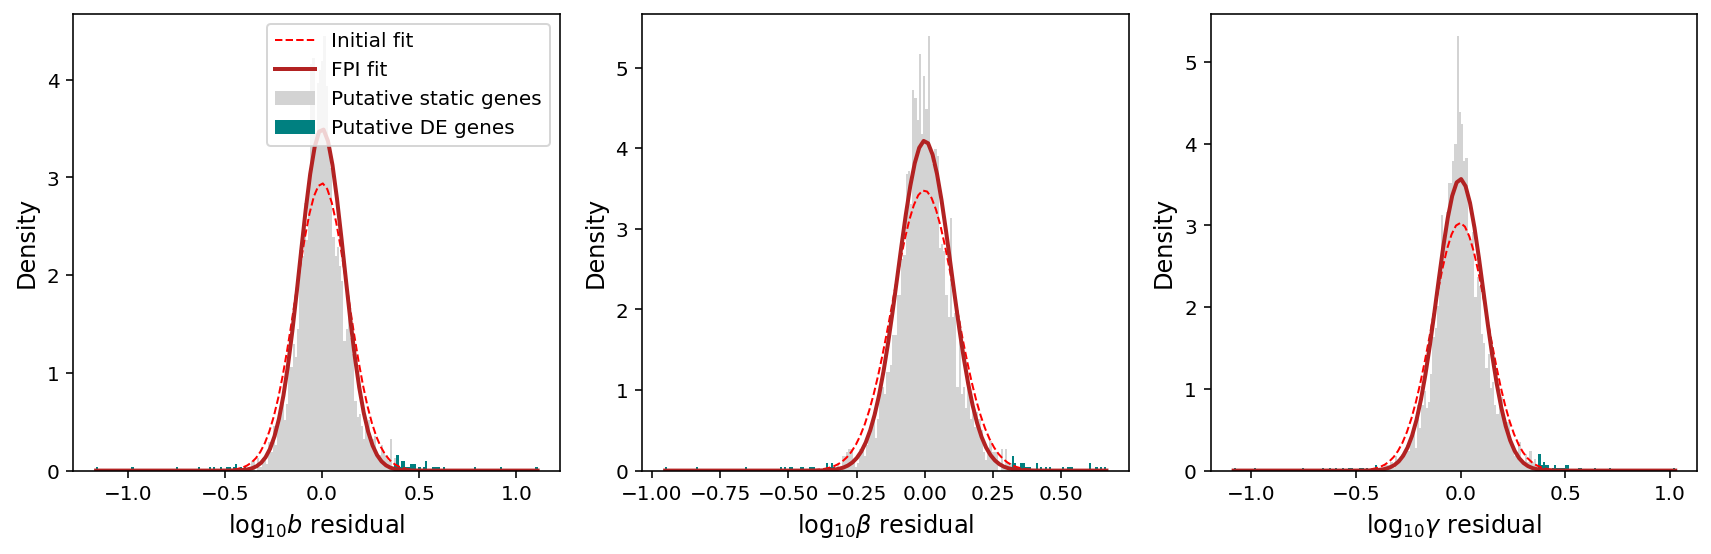

In [476]:
#Compare  0h vs 2h
test = make_fcs_srs(sr_arr_monod[0],sr_arr_monod[1],
                    sd_arr_monod[0],sd_arr_monod[1],
                    sr_arr_monod[0].gene_names,
                    gf_rej=True,thrpars=2,thrmean=0.1,correct_off=True)


In [477]:
test[test.deTheta_FC.isin([True]) & test.gene.isin(markers)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
630,True,-3.687371,FGD4,"[1, 2]",True,False,b


In [478]:
test[test.deTheta_FC.isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
630,True,-3.687371,FGD4,"[1, 2]",True,False,b
1364,True,-2.017882,COX7A2L,"[1, 2]",True,True,b
1621,True,2.122396,RIN2,"[1, 2]",True,True,b
1624,True,-2.592850,PYGB,"[1, 2]",True,True,b
2119,True,2.485904,MAST4,"[1, 2]",True,True,b
2375,True,3.863784,AHR,"[1, 2]",True,True,b
2473,True,-2.082048,SYBU,"[1, 2]",True,False,b
2502,True,3.251586,EXTL3,"[1, 2]",True,True,b
3006,True,-2.097824,ZFAND4,"[1, 2]",True,True,beta
4091,True,-2.022107,COX7A2L,"[1, 2]",True,True,beta


In [479]:
out_marks = get_gene_DE(test)

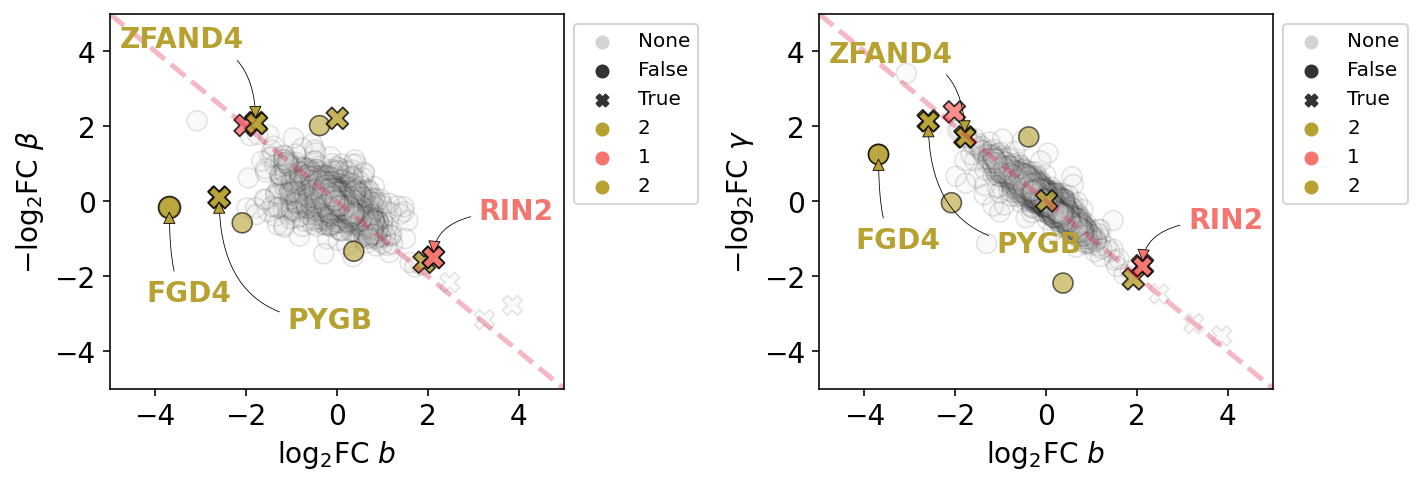

In [503]:
names_plot = ['FGD4','ZFAND4','RIN2','PYGB'] #Tpm1 age-related https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8225046/
mark_plot = [2,2,1,2]
xpos = [-0.5,-3,1,1.5]
ypos = [-2.5,2,1,-3.5]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors={1:'#F4756E',2:'#B7A131','None':'lightgrey'},
        figsize=(10,3.5),fname='cao_0h_vs_2h.pdf',xlims=[-5,5])



In [ ]:
#https://en.wikipedia.org/wiki/PYGB
#ZFAND4 stress
#FGD4 known cortisol response

## **Run meK-Means**

In [21]:
#Threshold for filtering genes based on expression patterns
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    #((U_mean/S_mean) > 1.0) #labeled mRNA (new synth) is mainly intronic counts
    
    #(np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [22]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [23]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [24]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [25]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',log=True,figsize=(18, 5),palette='tab20',fname=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''
 
    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign 
        
    if log:
        plt.yscale('log')
    
    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette=palette,multiple="layer",alpha=0.6,
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))
    


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



In [26]:
#Test different values for K
Ks= [2,5,10]
all_looms = [loom_filepaths[-1]]*len(Ks)
all_markers = [markers]*len(Ks)

data_names = ['cao_k_'+str(i) for i in Ks]
all_cf = [cf[-1]]*len(Ks) #We are using both the 0h and 2h cells

In [27]:
all_looms

['/home/tchari/counts/cao_scifate/loom/sci-A549.loom',
 '/home/tchari/counts/cao_scifate/loom/sci-A549.loom',
 '/home/tchari/counts/cao_scifate/loom/sci-A549.loom']

In [156]:
dir_strings = []
data_strings = []
result_strings = []

#Filter for genes that meet thresholds and are in literature  
ds = lp.connect(all_looms[0])
g_names = ds.ra[attribute_names[1]]
num_genes = len(g_names)
num_cells = len(ds.ca[attribute_names[2]])

U = ds.layers['unspliced'][:,:].T
S = ds.layers['spliced'][:,:].T

ds.close()

U = U[all_cf[0],:]
S = S[all_cf[0],:]
#Filter for overdispersed *and* enough U/S counts for clustering
g_filt = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
g_filt_lit = pd.Categorical(g_names).isin(all_markers[0]+list(reddy.gene))


final_filt = (g_filt_lit  & g_filt) # | (g_filt_hvg & g_filt) #Filter hvgs + add lit genes
final_names = g_names[final_filt]

print(data_names[0]+' with '+str(len(final_names))+' genes')


#Define bounds for params
phys_lb = [-3.0, -3, -3 ] 
phys_ub = [4.2, 2.5, 2.5]  
samp_lb = [-6.222222222222222, -0.6999999999999997]
samp_ub = [-6.222222222222222, -0.6999999999999997] 
gridsize = [1,1] #Already have tech params

epochs = 10

#Set up files for Monod
dir_string,dataset_string = monod.preprocess.construct_batch(all_looms, \
                                         transcriptome_filepath, \
                                         data_names, \
                                         attribute_names=attribute_names,\
                                         batch_location='./fits/explorCao_0405',\
                                         meta='meK',batch_id=2,\
                                         n_genes=len(final_names),exp_filter_threshold=None,
                                         viz=False,genes_to_fit=final_names,cf=all_cf)  #batch_id=1


    # ---------------- meK-Means Inference ---------------- 
for x in range(len(dataset_string)):
    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_string[x],fitmodel,k=Ks[x], epochs=epochs ,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(all_looms[x], transcriptome_filepath, data_names[x],
                dataset_string[x], dir_string, viz=False, dataset_attr_names=attribute_names,cf=all_cf[x])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

    result_strings.append(full_result_string)
    print('Result: ',full_result_string)


cao_k_2 with 45 genes
INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2 created.


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


INFO:root:Dataset: cao_k_2
INFO:root:2340 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4756 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2 created.
INFO:root:Dataset: cao_k_5
INFO:root:2340 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4756 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5 created.
INFO:root:Dataset: cao_k_10
INFO:root:2340 cells detected.
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:4756 genes retained after expression filter.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10 created.
INFO:root:Total of 45 genes selected.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2/Bursty_Poisson_1x1 created.
INFO:root:Global inference p

/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.81788474 0.18211526]
Q Function:  -131253.2512263576

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.73260674 0.26739326]
Q Function:  -127668.0954683988

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.90951551 0.09048449]
Q Function:  -129784.70260758506

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99995202e-01 4.79776095e-06]
Q Function:  -128615.97354228186

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.95435566e-10]
Q Function:  -128322.42306570004

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.27357458e-10]
Q Function:  -128322.41183718067

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.27356492e-10]
Q Function:  -128322.41183702131

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.27356492e-10]
Q Function:  -128322.41183702131

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.27356492e-10]
Q Function:  -128322.41183702131

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.00000000e+00 4.27356492e-10]
Q Function:  -128322.41183702131

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2/Bursty_Poisson_1x1/analysis_figures_0 created.
INFO:root:Runtime: 58.3 seconds.
Result:  ['./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2/Bursty_Poisson_1x1/grid_scan_results_0.res']
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_k_5
INFO:root:63568 features observed, 37922 match genome annotations. 32005 were unique.
INFO:root:Gene list extracted from ./fits/explorCao_0405/gg_240408_029_meK_2/genes.csv.
INFO:root:Search data stored to ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/raw.sd.
INFO:root:

/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03821032 0.32277954 0.28522461 0.05450752 0.29927801]
Q Function:  -128021.16898119176

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.05889512 0.10886326 0.21745771 0.12735946 0.48742446]
Q Function:  -133465.5927352818

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.64it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.06814024e-05 4.57833481e-02 2.30578765e-01 2.30659550e-01
 4.92957656e-01]
Q Function:  -126974.24861860031

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.60it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.59379092e-08 7.27649800e-03 2.91756307e-02 3.03132233e-01
 6.60415622e-01]
Q Function:  -128131.50580190908

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.37232653e-10 4.89507906e-10 7.01148719e-03 3.36396261e-01
 6.56592250e-01]
Q Function:  -125714.76741214216

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27526246e-10 4.27350434e-10 3.86639525e-04 3.60838194e-01
 6.38775166e-01]
Q Function:  -125554.23395112072

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27489034e-10 4.27350433e-10 4.27350426e-10 3.81191043e-01
 6.18808955e-01]
Q Function:  -125483.49973471156

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27514992e-10 4.27350434e-10 4.27350426e-10 3.99988658e-01
 6.00011341e-01]
Q Function:  -125398.96787078596

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27537712e-10 4.27350438e-10 4.27350426e-10 4.12378177e-01
 5.87621821e-01]
Q Function:  -125342.99150017905

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27533200e-10 4.27350437e-10 4.27350426e-10 4.17499332e-01
 5.82500667e-01]
Q Function:  -125345.66817012255

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/analysis_figures_3 created.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/analysis_figures_4 created.
INFO:root:Runtime: 61.0 seconds.
Result:  ['./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/grid_scan_results_4.res']
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: cao_k_10
INFO:root:63

/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13060446 0.02159941 0.164771   0.26457473 0.16544541 0.01644658
 0.0332535  0.01294559 0.02422439 0.16613493]
Q Function:  -131905.2452124324

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.81it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.45090786e-02 3.28983492e-05 5.58283405e-02 5.44193513e-01
 3.35898680e-01 3.47021903e-06 8.04349678e-05 1.18344951e-06
 2.39477743e-03 4.70576237e-02]
Q Function:  -131930.94995489393

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.44855822e-04 7.56969134e-06 4.85056724e-02 5.61461354e-01
 3.84334145e-01 4.89269661e-10 4.19219564e-08 4.83173336e-10
 4.27350426e-10 4.84635938e-03]
Q Function:  -126048.28904910406

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 9.69261577e-07 2.52896513e-02 5.69032422e-01
 4.04413792e-01 4.27371285e-10 4.48126172e-10 4.27386960e-10
 4.27350426e-10 1.26316372e-03]
Q Function:  -125540.56940049893

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 1.27363856e-07 1.80014756e-02 5.71062809e-01
 4.10935585e-01 4.27364130e-10 4.27563751e-10 4.27388434e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125437.38656628168

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 1.57365939e-08 2.45323572e-03 5.70600407e-01
 4.26946339e-01 4.27361785e-10 4.27560019e-10 4.27389256e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125409.92899029431

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 2.33532879e-09 8.11183704e-04 5.71938927e-01
 4.27249885e-01 4.27363340e-10 4.27590932e-10 4.27390880e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125306.163209236

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.34it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 7.31537664e-10 4.27350853e-04 5.72182230e-01
 4.27390415e-01 4.27364328e-10 4.27591917e-10 4.27382727e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125325.77465955754

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.28it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 5.24904778e-10 4.27350426e-10 5.71862995e-01
 4.28137002e-01 4.27364113e-10 4.27591106e-10 4.27382994e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125357.70678377089

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.30it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.27350426e-10 4.97374011e-10 4.27350426e-10 5.71570962e-01
 4.28429035e-01 4.27364122e-10 4.27591660e-10 4.27383013e-10
 4.27350426e-10 4.27350426e-10]
Q Function:  -125356.9051527653

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/analysis_figures_3 created.
INFO:root:Directory ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/analysis_figures_4 created.
INFO:root:Runtime: 59.3 seconds.
Result:  ['./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/grid_scan_results_4.res']


In [28]:
dir_string = './fits/explorCao_0405/gg_240408_029_meK_2'

In [29]:
to_find = [dir_string+'/'+d+'/Bursty_Poisson_1x1/*.res' for d in data_names]

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [30]:
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr)

INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/grid_scan_results_3.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/Bursty_Poisson_1x1/grid_scan_results_4.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/grid_scan_results_3.res.
INFO:root:Grid scan results loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/Bursty_Poisson_1x1/grid_scan_results_4.res.


3

In [31]:
#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_2/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_5/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/raw.sd.
INFO:root:Search data loaded from ./fits/explorCao_0405/gg_240408_029_meK_2/cao_k_10/raw.sd.


3

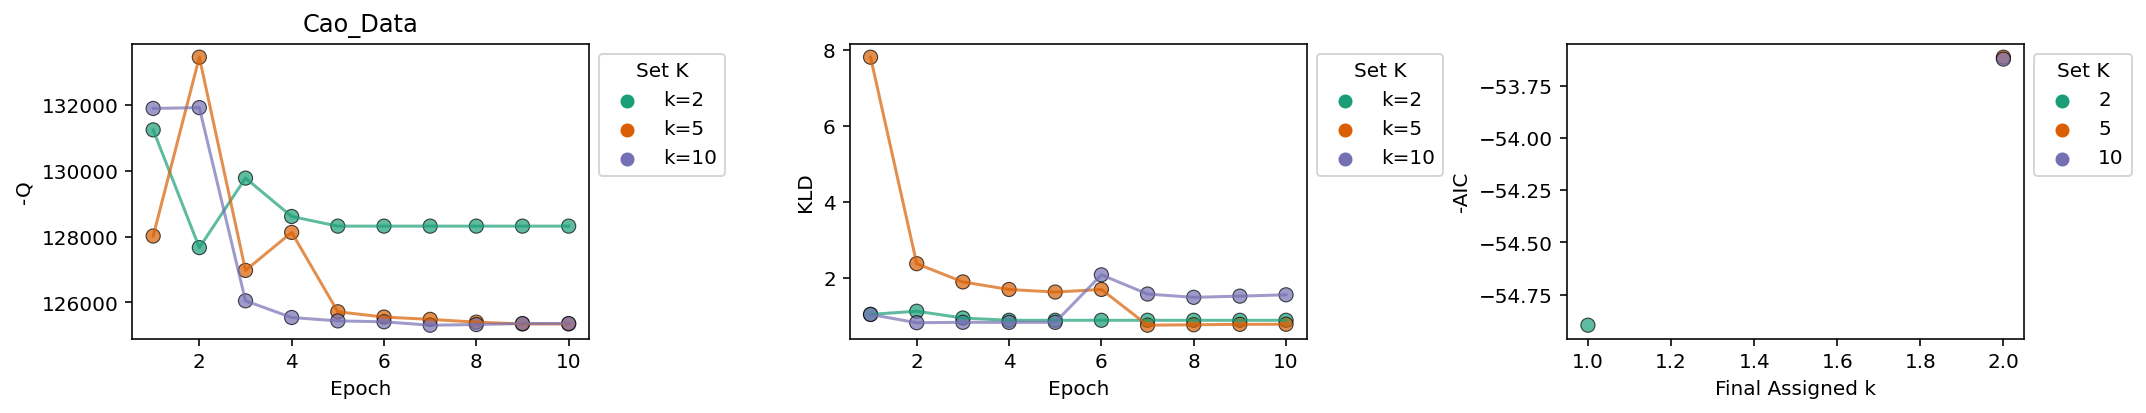

In [32]:
vis_metrics(sr,'Cao_Data',Ks,figsize=(15,3),fname='cao_k_metrics.pdf')

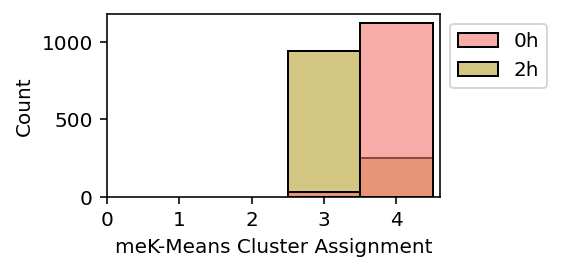

In [33]:
#Palette is from study, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7416490/#R28
r = sr[1]
true_labs = [list(meta['treatment_time'][meta['sample'].isin([i])])[0] for i in cellids[all_cf[-1]]]
vis_assign(get_assigns(r),true=true_labs,log=False,title='',palette={'0h':'#F4756E','2h':'#B7A131'},
           figsize=(4, 2),fname='cao_clus_hist.pdf')

In [43]:
#Compare parameters to previous fits
overlap = list(set(sr_arr_monod[1].gene_names).intersection(r[0].gene_names)) #Get genes that overlap in both

In [44]:
cat_gene_names = pd.Categorical(r[0].gene_names)
cat_old_gene_names = pd.Categorical(sr_arr_monod[1].gene_names)

In [45]:
r[0].assigns

3

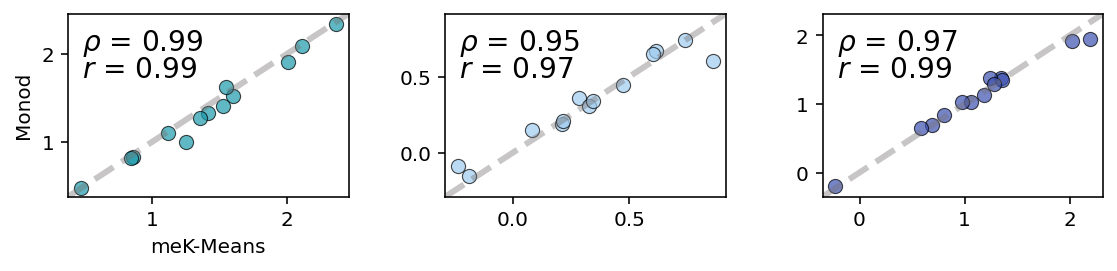

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2))
rho =[]
p = [] 

#Colors
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'

#b vs b
g=sns.scatterplot(x=r[0].param_estimates[0,cat_gene_names.isin(overlap),0],
                  y=sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),0],
                    s=50,edgecolor='black',color=col_b, alpha=0.7,ax=ax[0],legend=False)

rho += [np.corrcoef(r[0].param_estimates[0,cat_gene_names.isin(overlap),0],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),0])[0,1]]
p += [scipy.stats.spearmanr(r[0].param_estimates[0,cat_gene_names.isin(overlap),0],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),0])[0]]


#beta vs beta
g1=sns.scatterplot(x=r[0].param_estimates[0,cat_gene_names.isin(overlap),1],
                  y=sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),1],
                    s=50,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1],legend=False)

rho += [np.corrcoef(r[0].param_estimates[0,cat_gene_names.isin(overlap),1],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),1])[0,1]]
p += [scipy.stats.spearmanr(r[0].param_estimates[0,cat_gene_names.isin(overlap),1],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),1])[0]]


g2=sns.scatterplot(x=r[0].param_estimates[0,cat_gene_names.isin(overlap),2],
                  y=sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),2],
                    s=50,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2],legend=False)

rho += [np.corrcoef(r[0].param_estimates[0,cat_gene_names.isin(overlap),2],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),2])[0,1]]
p += [scipy.stats.spearmanr(r[0].param_estimates[0,cat_gene_names.isin(overlap),2],
                    sr_arr_monod[1].param_estimates[0,cat_old_gene_names.isin(overlap),2])[0]]


ax[0].set_xlabel('meK-Means')
ax[0].set_ylabel('Monod')

for i, a in enumerate(ax.flat):


        bot,top = a.get_ylim()
        left,right = a.get_xlim()

        newl = np.min([bot,left])
        newr = np.max([top,right])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.65,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)


plt.tight_layout()
plt.savefig('cao_meK_Monod_comparison.pdf')

In [35]:
reddy[reddy.gene.isin(list(r[0].gene_names))]

,gene,dex.r1,dex.r2,etoh.r1,etoh.r2,Log2 Ratio,# Peaks,Reference,Isoform,RT-QPCR Fold,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,PTGER4,2.3777,2.7362,0.2474,0.2835,3.267912,0,0.0,uc003jlz.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TSC22D3,26.6323,27.6177,2.9950,3.3412,3.097933,0,1.0,uc004eng.1,2.966667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PER1,15.4796,17.7402,3.2800,2.4286,2.540835,2,6.0,uc002gkd.1,2.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,TFCP2L1,1.9667,2.4104,0.4407,0.6618,1.989197,1,NaN,uc002tmx.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,F3,4.3763,4.7123,1.2600,1.1348,1.924153,0,NaN,uc001dqs.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,ANGPTL4,62.6674,71.3137,17.8572,17.4999,1.921958,2,1.0,uc002mjq.1,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,BIRC3,8.9297,9.5939,2.2502,2.8154,1.870559,2,1.0,uc001pgx.1,0.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PDK4,5.7818,5.9345,1.3912,2.1663,1.719581,0,NaN,uc003uoa.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,CIDEC,8.7531,10.1301,3.4907,2.3217,1.699897,2,NaN,uc003ctp.1,2.633333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,KLF6,33.3326,32.4730,11.3865,11.1531,1.545748,0,NaN,uc001iha.1,1.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
sr_labels = get_assigns(r)

In [79]:
bound_filt = (~check_at_bounds(r[0].param_estimates[0,:,:])) & (~check_at_bounds(r[1].param_estimates[0,:,:]))

betas = list(r[0].param_estimates[0,bound_filt ,1])+list(r[1].param_estimates[0,bound_filt ,1])
bs = list(r[0].param_estimates[0,bound_filt ,0])+list(r[1].param_estimates[0,bound_filt ,0])
gammas = list(r[0].param_estimates[0,bound_filt ,2])+list(r[1].param_estimates[0,bound_filt ,2])
states = ['2h']*np.sum(bound_filt) + ['0h']*np.sum(bound_filt)
state_genes = list(r[0].gene_names[bound_filt])*2

param_states = pd.DataFrame()

In [80]:
len(bound_filt)

45

In [81]:
param_states['beta'] = betas
param_states['gamma'] = gammas
param_states['b'] = bs
param_states['state'] = states
param_states['gene'] = state_genes
param_states.head()

,beta,gamma,b,state,gene
0,-0.223547,2.159350,2.013154,2h,ERRFI1
1,0.212398,0.694142,0.856191,2h,EPHA2
2,0.285378,0.808203,0.845538,2h,E2F2
3,0.690281,1.436264,1.355024,2h,F3
4,-0.106928,0.956834,1.377949,2h,SLC19A2


<Figure size 720x360 with 0 Axes>

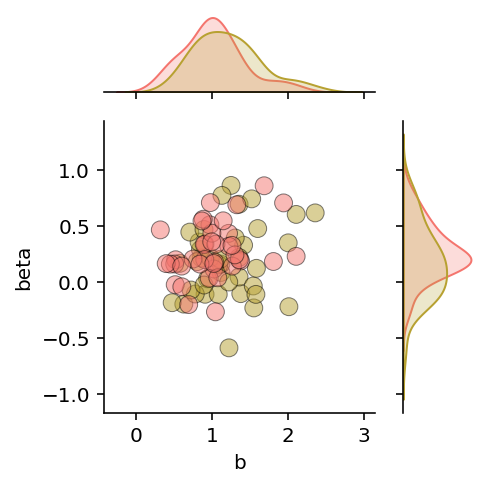

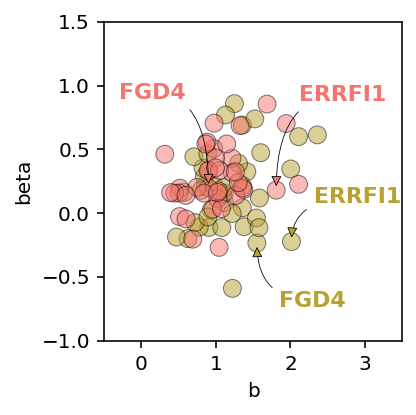

In [117]:
palette={'0h':'#F4756E','2h':'#B7A131'}
    
plt.figure(figsize=(10,5))

sns.jointplot(data=param_states, x="b", y="beta", hue="state",
              alpha=0.5,s=80,height=3.5,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False},
             edgecolor='black',linewidth=0.5)

plt.xticks(fontsize=50)

plt.tight_layout()
plt.savefig('cao_jointplot_0h2h.pdf')


fig,ax = plt.subplots(1,1,figsize=(3,3))

sns.scatterplot(data=param_states, x="b", y="beta", hue="state",
              alpha=0.5,s=80,
              palette=palette,legend=False,
             edgecolor='black',linewidth=0.5,ax=ax)

ax.set_ylim([-1,1.5])
ax.set_xlim([-0.5,3.5])

#'FGD4','ERRFI1'

x = list(param_states.b[param_states.gene.isin(['FGD4']) & param_states.state.isin(['2h'])])[0]
y = list(param_states.beta[param_states.gene.isin(['FGD4']) & param_states.state.isin(['2h'])])[0]
ax.annotate('FGD4', (x, y), fontsize=11,
                               xytext=(x+0.3,y-0.5),weight="bold", color=palette['2h'],
                           arrowprops = dict(facecolor=palette['2h'],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))


x = list(param_states.b[param_states.gene.isin(['FGD4']) & param_states.state.isin(['0h'])])[0]
y = list(param_states.beta[param_states.gene.isin(['FGD4']) & param_states.state.isin(['0h'])])[0]
ax.annotate('FGD4', (x, y), fontsize=11,
                               xytext=(x-1.2,y+0.7),weight="bold", color=palette['0h'],
                           arrowprops = dict(facecolor=palette['0h'],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))


x = list(param_states.b[param_states.gene.isin(['ERRFI1']) & param_states.state.isin(['2h'])])[0]
y = list(param_states.beta[param_states.gene.isin(['ERRFI1']) & param_states.state.isin(['2h'])])[0]
ax.annotate('ERRFI1', (x, y), fontsize=11,
                               xytext=(x+0.3,y+0.3),weight="bold", color=palette['2h'],
                           arrowprops = dict(facecolor=palette['2h'],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))


x = list(param_states.b[param_states.gene.isin(['ERRFI1']) & param_states.state.isin(['0h'])])[0]
y = list(param_states.beta[param_states.gene.isin(['ERRFI1']) & param_states.state.isin(['0h'])])[0]
ax.annotate('ERRFI1', (x, y), fontsize=11,
                               xytext=(x+0.3,y+0.7),weight="bold", color=palette['0h'],
                           arrowprops = dict(facecolor=palette['0h'],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))


plt.tight_layout()
plt.savefig('cao_scatter_0h2h.pdf')


Comparison of mean count distributions (2h cells in clusters 3,4, 0h cells in clusters 3,4)

In [308]:
#Plot of mean expression across cells in 2h populations
#Save original log2 ratio of genes

meK_res = pd.DataFrame()

mean_3 = []
mean_4 = []

log2Ratio = []
r_g_names = []
reddy_genes = list(reddy.gene[reddy['gene'].isin(sd[1][0].gene_names)])

for r_g in reddy_genes:
    which_ind = pd.Categorical(sd[1][0].gene_names).isin([r_g])
    sub_sd = sd[1][0].layers[1][which_ind,:]
    
    which_cells = (sr_labels==3)&(np.array(true_labs)=='2h')
    mean_3 += [np.mean(sub_sd[0,which_cells])]
    log2Ratio += [list(reddy['Log2 Ratio'][reddy.gene.isin([r_g])])[0]]
    
    r_g_names +=[r_g]
    
    which_cells = (sr_labels==4)&(np.array(true_labs)=='2h')
    mean_4 += [np.mean(sub_sd[0,which_cells])]

    
meK_res['Mean_3'] = mean_3
meK_res['Mean_4'] = mean_4
meK_res['Log2_Ratio'] = log2Ratio
meK_res['Gene'] = r_g_names
meK_res.head()

,Mean_3,Mean_4,Log2_Ratio,Gene
0,0.354942,0.072581,3.267912,PTGER4
1,1.487779,0.330645,3.097933,TSC22D3
2,0.759830,0.233871,2.540835,PER1
3,0.476089,0.209677,1.989197,TFCP2L1
4,0.165781,0.060484,1.924153,F3


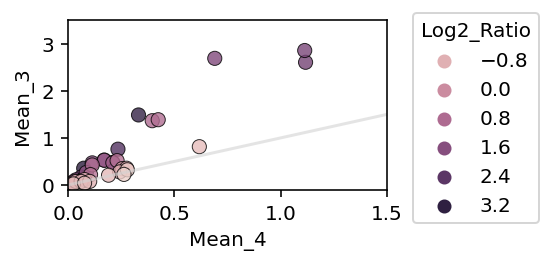

In [328]:
plt.figure(figsize=(4,2))
sub_meK_res = meK_res[(meK_res['Log2_Ratio'] > 0.5 )| (meK_res['Log2_Ratio'] < -0.5 )]

g=sns.scatterplot(data=sub_meK_res,x='Mean_4',y='Mean_3',hue='Log2_Ratio',
                s=50,alpha=0.8,edgecolor='black',linewidth=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1.1))

plt.plot(range(0,3),range(0,3),color='lightgrey',alpha=0.6)
plt.xlim([0,1.5])
plt.ylim([-0.1,3.5])
plt.tight_layout()
plt.savefig('cao_pops_reddy_logFC.pdf') #Supp Fig

**Code for Leiden Comparison**

In [399]:
#Perform standard normalization (read-depth + log1p)
def norm_mat(mat,new_tot=1e4):
    '''
    mat: cell x gene matrix
    '''  
    tots = np.sum(mat,axis=1)
    divids = (new_tot/tots)[:,None]
    mat_norm = mat*divids
    mat_norm = np.log1p(mat_norm)
    
    mat_norm[np.isnan(mat_norm)] = 0
    
    return mat_norm

In [170]:
def get_graph(mat,neigh=30):
    A = kneighbors_graph(mat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    return g

In [200]:
ms = [S[:,g_filt_lit],U[:,g_filt_lit], 
        S[:,g_filt_lit]+U[:,g_filt_lit],
        np.concatenate([U[:,g_filt_lit],S[:,g_filt_lit]],axis=1)]
res = 1.0

meths = []
result = []
hyper = []
mats = []

leid_res = pd.DataFrame()

for m in ms:
    new_S = m
    S_norm = norm_mat(new_S)
    g_S = get_graph(S_norm)

    partition_type = la.RBConfigurationVertexPartition
    part = la.find_partition(g_S, partition_type, 
                                            weights=np.array(g_S.es['weight']).astype(np.float64), 
                                            n_iterations=-1, resolution_parameter=res)

    labels = np.array(part.membership)

    new_labs = [str(x) for x in labels]
    new_labs = "|".join(new_labs)
    
    meths += ['Leiden']

    result += [new_labs]
    hyper += [res]
    
mats += ['U','S','U+S','UcatS']
    
leid_res['Method'] = meths
leid_res['Clustering'] = result
leid_res['Matrices'] = mats
leid_res['Hyperparam'] = hyper

leid_res.to_csv('cao_leiden_res.csv',index=None)
leid_res

in loop
in loop


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


in loop
in loop


,Method,Clustering,Matrices,Hyperparam
0,Leiden,1|2|1|0|2|0|0|1|3|1|3|1|1|0|1|3|0|0|1|0|3|1|1|...,U,1.0
1,Leiden,1|2|1|0|0|0|0|1|0|1|1|3|1|0|1|0|0|0|1|0|2|3|1|...,S,1.0
2,Leiden,1|5|1|0|1|0|0|1|3|1|3|1|1|0|1|3|0|0|1|0|3|1|1|...,U+S,1.0
3,Leiden,2|5|2|3|1|0|0|1|3|2|3|2|2|0|1|3|0|0|1|0|3|2|2|...,UcatS,1.0


In [203]:
leid_res = pd.read_csv('cao_leiden_res.csv')

#Get all pairs of Leiden runs
individs = [leid_res.iloc[i]['Method']+'_'+leid_res.iloc[i]['Matrices'] for i in range(len(leid_res))]
pos = range(len(leid_res))
individs

['Leiden_U', 'Leiden_S', 'Leiden_U+S', 'Leiden_UcatS']

In [207]:
pairs = list(itertools.combinations(pos, 2))
aris_pairs = np.zeros([len(pos),len(pos)]) 
for p in pairs:
    out = adjusted_rand_score(leid_res.iloc[p[0]]['Clustering'].split('|'),leid_res.iloc[p[1]]['Clustering'].split('|'))
    aris_pairs[p[0],p[1]] = out
    aris_pairs[p[1],p[0]] = out

aris_pairs = aris_pairs + np.eye(len(pos),len(pos)) 



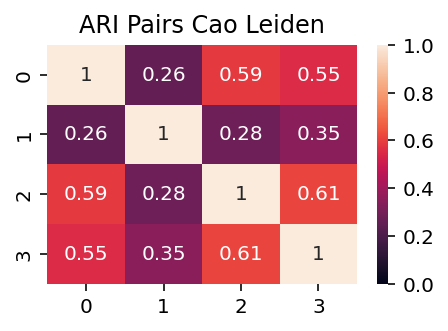

In [447]:
plt.figure(figsize=(3.25,2.25))
sns.heatmap(aris_pairs, annot = True,vmin=0, vmax=1.0)
plt.tight_layout()
plt.title('ARI Pairs Cao Leiden')
plt.savefig('ARI_pairs_cao_leiden.pdf')

In [217]:
leid_res['Num_Clus'] = [len(np.unique(i.split('|'))) for i in leid_res['Clustering']]

In [224]:
palette = {'U':'#FFCCCC', 'S':'#003366', 'U+S':'#8C879E', 'UcatS':'#809499', 'U,S':'#ffcc66'}

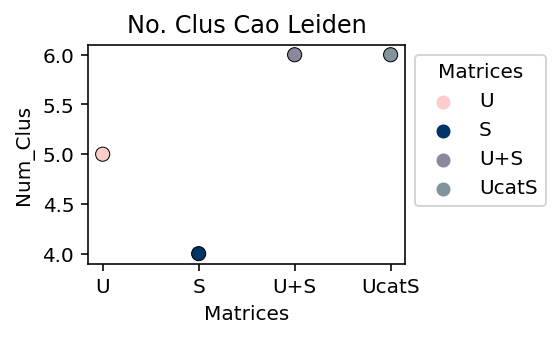

In [455]:
plt.figure(figsize=(4,2.25))
g=sns.scatterplot(data=leid_res, x='Matrices',y='Num_Clus',hue='Matrices',
                s=50,
                edgecolor='black',linewidth=0.5,palette=palette)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('No. Clus Cao Leiden')
plt.savefig('numClus_pairs_cao_leiden.pdf')

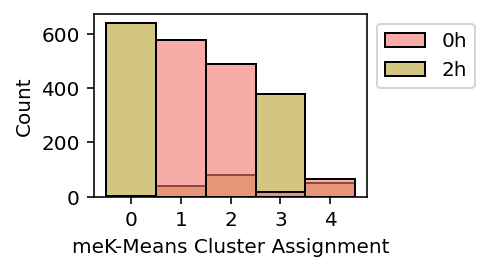

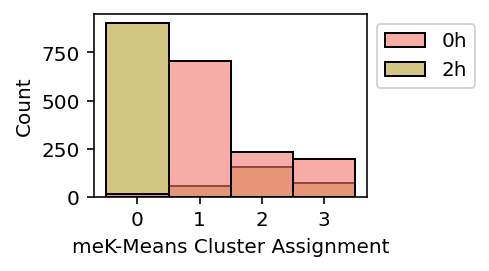

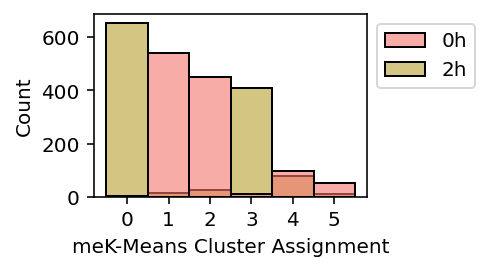

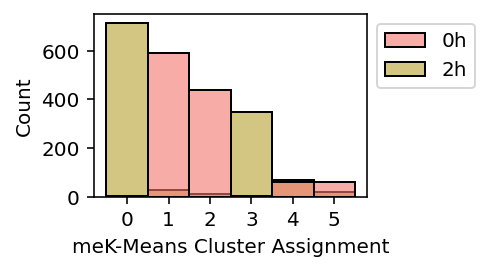

In [462]:
for pos in range(len(leid_res)):
    mat_name = leid_res.iloc[pos]['Matrices']
    labels = leid_res.iloc[pos]['Clustering'].split('|')
    labels = [int(i) for i in labels]
    vis_assign(labels,true=true_labs,log=False,title='',figsize=(3.5,2),fname='cao_clus_hist_leiden_'+mat_name+'.pdf',
               palette={'0h':'#F4756E','2h':'#B7A131'})

